# AutoMISC v0.2

Main idea: we aim to achieve higher fine-grained MISC accuracy by clustering more semantically similar codes together first in a primary classification round followed by subsequent finer-grained classification rounds.

In [4]:
from openai import OpenAI
from pydantic import BaseModel
from typing import Literal, List
import pandas as pd
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

openai_client = OpenAI()

# Analysis

## Cohen's Kappa

In [2]:
def compute_p0_pe(y1, y2):
    cm = confusion_matrix(y1, y2)
    total = np.sum(cm)
    p0 = np.trace(cm) / total
    row_marginals = np.sum(cm, axis=1) / total
    col_marginals = np.sum(cm, axis=0) / total
    pe = np.sum(row_marginals * col_marginals)
    return p0, pe, cm, row_marginals, col_marginals

def compute_asymptotic_variance_kappa(p0, pe, cm, row_marginals, col_marginals, n):
    theta_1 = p0  # Observed agreement
    theta_2 = pe  # Expected agreement
    total = np.sum(cm)
    p_ij = cm / total
    theta_3 = np.sum(np.diag(p_ij) * (row_marginals + col_marginals))
    theta_4 = np.sum([
        p_ij[i, j] * (row_marginals[i] + col_marginals[j]) ** 2
        for i in range(p_ij.shape[0])
        for j in range(p_ij.shape[1])
    ])
    var_kappa = (1 / n) * (
        (theta_1 * (1 - theta_1)) / (1 - theta_2) ** 2 +
        (2 * (1 - theta_1) * (2 * theta_1 * theta_2 - theta_3)) / (1 - theta_2) ** 3 +
        ((1 - theta_1) ** 2 * (theta_4 - 4 * theta_2 ** 2)) / (1 - theta_2) ** 4
    )
    return var_kappa

def compute_p_value(kappa, var_kappa):
    z_score = kappa / np.sqrt(var_kappa)
    print(f'Z-score: {z_score}')
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return p_value

def cohens_kappa(file_path, tier, rater_name, n):

    data = pd.read_csv(file_path, nrows=n)

    client_codes_map = {
        'T1': ["C", "S", "N"],
        'T2': ["TS-", "AC-", "C-", "N-", "R-", "AB-", "D-", "O-", "N", "O+", "D+", "AB+", "R+", "N+", "C+", "AC+", "TS+"]
    }
    counsellor_code_map = {
        'T1': ["CRL", "SRL", "IMC", "IMI", "Q", "O"],
        'T2': ["CR", "AF", "SU", "RF", "EC", "SR", "ADP", "RCP", "GI", "ADW", "CO", "DI", "RCW", "WA", "OQ", "CQ", "FA", "FI", "ST"]
    }
        
    counsellor_codes = counsellor_code_map[tier]
    client_codes = client_codes_map[tier]

    human_labels = data[f'{tier} Label ({rater_name})']
    automisc_labels = data[f'{tier} Label (AutoMISC)']
    filtered_human_labels = human_labels[human_labels.isin(counsellor_codes + client_codes)]
    filtered_automisc_labels = automisc_labels[automisc_labels.isin(counsellor_codes + client_codes)]

    # Ensure both series are aligned
    filtered_human_labels = filtered_human_labels[filtered_human_labels.index.isin(filtered_automisc_labels.index)]
    filtered_automisc_labels = filtered_automisc_labels[filtered_automisc_labels.index.isin(filtered_human_labels.index)]

    # --------------------- Counsellor Calculations ---------------------
    counsellor_human_labels = filtered_human_labels[filtered_human_labels.isin(counsellor_codes)]
    counsellor_automisc_labels = filtered_automisc_labels[filtered_automisc_labels.isin(counsellor_codes)]

    co_po, co_pe, cm_co, row_marginals_co, col_marginals_co = compute_p0_pe(counsellor_human_labels, counsellor_automisc_labels)
    man_co = (co_po - co_pe) / (1 - co_pe)

    kappa_score_counsellor = cohen_kappa_score(counsellor_human_labels, counsellor_automisc_labels)
    av_counsellor = compute_asymptotic_variance_kappa(co_po, co_pe, cm_co, row_marginals_co, col_marginals_co, len(counsellor_human_labels))
    p_co = compute_p_value(kappa_score_counsellor, av_counsellor)

    print(f"Cohen's Kappa ({tier} Counsellor Codes): {kappa_score_counsellor:.2f}")
    print(f"Manual Cohen's Kappa ({tier} Counsellor): {man_co:.2f}")
    
    
    print(f"Asymptotic Variance ({tier} Counsellor): {av_counsellor}")
    print(f"P-value ({tier} Counsellor): {p_co:.15e}")

    # (Optional) Plot confusion matrix and classification report for counsellor codes
    counsellor_conf_matrix = confusion_matrix(
        counsellor_human_labels, counsellor_automisc_labels, labels=counsellor_codes
    )
    counsellor_conf_matrix_df = pd.DataFrame(
        counsellor_conf_matrix,
        index=counsellor_codes,
        columns=counsellor_codes
    )

    total_correct_counsellor = np.trace(counsellor_conf_matrix)
    print(f"\nTotal Correct Predictions (Counsellor): {total_correct_counsellor} / {len(counsellor_human_labels)} = {co_po*100:.2f}%")
    # print(f"Agreement ({tier} Counsellor): {co_po:.2f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(counsellor_conf_matrix_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {tier} Counsellor Talk")
    plt.xlabel("AutoMISC")
    plt.ylabel("Human")
    plt.show()

    class_report_counsellor = classification_report(counsellor_human_labels, counsellor_automisc_labels, labels=counsellor_codes, output_dict=True, zero_division=0)
    class_report_counsellor_df = pd.DataFrame(class_report_counsellor).transpose()
    class_report_counsellor_df = class_report_counsellor_df.style.set_caption("Classification Report: Counsellor Talk")
    display(class_report_counsellor_df)

    # --------------------- Client Calculations ---------------------
    client_human_labels = filtered_human_labels[filtered_human_labels.isin(client_codes)]
    client_automisc_labels = filtered_automisc_labels[filtered_automisc_labels.isin(client_codes)]

    cl_po, cl_pe, cm_cl, row_marginals_cl, col_marginals_cl = compute_p0_pe(client_human_labels, client_automisc_labels)
    man_cl = (cl_po - cl_pe) / (1 - cl_pe)

    kappa_score_client = cohen_kappa_score(client_human_labels, client_automisc_labels)
    av_client = compute_asymptotic_variance_kappa(cl_po, cl_pe, cm_cl, row_marginals_cl, col_marginals_cl, len(client_human_labels))
    p_client = compute_p_value(kappa_score_client, av_client)

    print(f"Cohen's Kappa ({tier} Client Codes): {kappa_score_client:.2f}")
    print(f"Manual Cohen's Kappa ({tier} Client): {man_cl:.2f}")
    # print(f"Agreement ({tier} Client): {cl_po:.2f}")
 
    
    print(f"Asymptotic Variance ({tier} Client): {av_client}")
    print(f"P-value ({tier} Client): {p_client:.15e}")

    # (Optional) Plot confusion matrix and classification report for client codes
    client_conf_matrix = confusion_matrix(
        client_human_labels, client_automisc_labels, labels=client_codes
    )
    client_conf_matrix_df = pd.DataFrame(
        client_conf_matrix,
        index=client_codes,
        columns=client_codes
    )
    total_correct_client = np.trace(client_conf_matrix)
    print(f"Total Correct Predictions (Client): {total_correct_client}")
    print(f"\nTotal Correct Predictions (Client): {total_correct_client} / {len(client_human_labels)} = {cl_po*100:.2f}%")


    plt.figure(figsize=(8, 6))
    sns.heatmap(client_conf_matrix_df, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Confusion Matrix: {tier} Client Talk")
    plt.xlabel("AutoMISC")
    plt.ylabel("Human")
    plt.show()

    class_report_client = classification_report(client_human_labels, client_automisc_labels, labels=client_codes, output_dict=True, zero_division=0)
    class_report_client_df = pd.DataFrame(class_report_client).transpose()
    class_report_client_df = class_report_client_df.style.set_caption("Classification Report: Client Talk")
    display(class_report_client_df)

Z-score: 28.10078546864149
Cohen's Kappa (T2 Counsellor Codes): 0.61
Manual Cohen's Kappa (T2 Counsellor): 0.61
Asymptotic Variance (T2 Counsellor): 0.00046594831007843184
P-value (T2 Counsellor): 0.000000000000000e+00

Total Correct Predictions (Counsellor): 382 / 580 = 65.86%


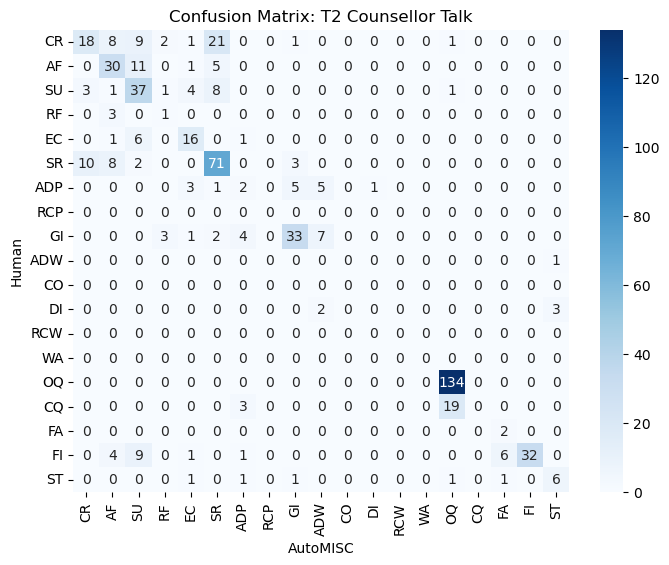

,precision,recall,f1-score,support
CR,0.580645,0.295082,0.391304,61.000000
AF,0.545455,0.638298,0.588235,47.000000
SU,0.500000,0.672727,0.573643,55.000000
RF,0.142857,0.250000,0.181818,4.000000
EC,0.571429,0.666667,0.615385,24.000000
SR,0.657407,0.755319,0.702970,94.000000
ADP,0.166667,0.117647,0.137931,17.000000
RCP,0.000000,0.000000,0.000000,0.000000
GI,0.767442,0.660000,0.709677,50.000000
ADW,0.000000,0.000000,0.000000,1.000000


Z-score: 14.312063136954347
Cohen's Kappa (T2 Client Codes): 0.51
Manual Cohen's Kappa (T2 Client): 0.51
Asymptotic Variance (T2 Client): 0.0012899592441920308
P-value (T2 Client): 0.000000000000000e+00
Total Correct Predictions (Client): 144

Total Correct Predictions (Client): 144 / 241 = 59.75%


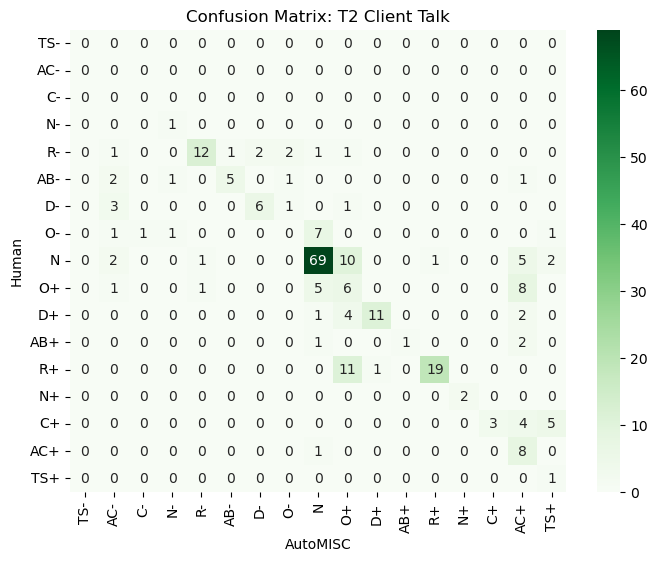

,precision,recall,f1-score,support
TS-,0.000000,0.000000,0.000000,0.000000
AC-,0.000000,0.000000,0.000000,0.000000
C-,0.000000,0.000000,0.000000,0.000000
N-,0.333333,1.000000,0.500000,1.000000
R-,0.857143,0.600000,0.705882,20.000000
AB-,0.833333,0.500000,0.625000,10.000000
D-,0.750000,0.545455,0.631579,11.000000
O-,0.000000,0.000000,0.000000,11.000000
N,0.811765,0.766667,0.788571,90.000000
O+,0.181818,0.285714,0.222222,21.000000


In [3]:
# file_path = 'MIV6.3A_automiscv0.2_aggregated_results_gemma_flat.csv'
file_path = 'MIV6.3A_automiscv0.2_aggregated_results_flat.csv'
# file_path = 'MIV6.3A_automiscv0.2_aggregated_results_flat.csv'


# cohens_kappa(file_path, 'T1', 'Soliman', 821)
cohens_kappa(file_path, 'T2', 'Soliman', 821)

# file_path = 'MIV6.3A_automiscv0.2_aggregated_results_flat.csv'
# cohens_kappa(file_path, 'T2', 'Soliman', 1000)


## Pairwise Cohen's Kappa Heatmap

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.preprocessing import LabelEncoder


def plot_pairwise_kappa_heatmap(data, raters, nrows=10000, tier="T2", speaker="counsellor", label_map=None):
    """
    data: DataFrame containing utterance-level labels
    raters: list of strings like ["AutoMISC", "Soliman", "Hannah", "Alex", "Aaron"]
    tier: "T1" or "T2"
    speaker: "counsellor" or "client"
    label_map: optional list of allowed labels
    """

    # Choose appropriate code space
    if speaker == "client":
        label_space = {
            "T1": ["C", "S", "N"],
            "T2": ["TS-", "AC-", "C-", "N-", "R-", "AB-", "D-", "O-", "N", "O+", "D+", "AB+", "R+", "N+", "C+", "AC+", "TS+"],
        }[tier]
    elif speaker == "counsellor":
        label_space = {
            "T1": ["CRL", "SRL", "IMC", "IMI", "Q", "O"],
            # "T1": ["R", "Q", "MICO", "MIIN", "Other"],
            "T2": ["CR", "AF", "SU", "RF", "EC", "SR", "ADP", "RCP", "GI", "ADW", "CO", "DI", "RCW", "WA", "OQ", "CQ", "FA", "FI", "ST"],
        }[tier]
    else:
        raise ValueError("speaker must be 'counsellor' or 'client'")

    # Override if custom label list is provided
    if label_map:
        label_space = label_map

    kappa_vals = []
    for r1, r2 in combinations(raters, 2):
        col1 = f"{tier} Label ({r1})"
        col2 = f"{tier} Label ({r2})"

        if col1 not in data.columns or col2 not in data.columns:
            continue  # Skip missing columns

        valid = data[col1].isin(label_space) & data[col2].isin(label_space)
        if valid.sum() == 0:
            continue

        y1 = data.loc[valid, col1]
        y2 = data.loc[valid, col2]
        kappa = cohen_kappa_score(y1, y2)
        kappa_vals.append((r1, r2, kappa))

    # Build square matrix
    rater_labels = raters
    mat = pd.DataFrame(index=rater_labels, columns=rater_labels, dtype=float)
    for r1, r2, val in kappa_vals:
        mat.loc[r1, r2] = val
        mat.loc[r2, r1] = val

    # Plot lower-triangular heatmap
    mat = mat.iloc[1:, :-1]
    mask = np.triu(np.ones_like(mat, dtype=bool), k=1)


    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    ax = sns.heatmap(
        mat.astype(float),
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        vmin=0.5,
        vmax=1.0,
        cbar_kws={"label": "Cohen's Kappa"}
    )

    plt.title(f"{tier} {speaker.capitalize()} Codes — Pairwise Cohen's Kappa", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ---- Fleiss' Kappa ----
    rating_matrix = []
    encoder = LabelEncoder().fit(label_space)
    disagreement_rows = []
    agreement_rows = []
    # print(len(data))

    for i, row in data.iterrows():
        labels = []
        for r in raters:
            col = f"{tier} Label ({r})"
            if col in row and pd.notna(row[col]) and row[col] in label_space:
                labels.append(row[col])
        
        if len(set(labels)) == 0:
            continue  
        # print(f'{labels}: {"agree" if len(set(labels)) == 1 else "disagree"}')

        if len(labels) != len(raters):
            print(labels)
            print(f'{i}, something fucked up')
            continue

        encoded = encoder.transform(labels)
        counts = np.bincount(encoded, minlength=len(label_space))
        rating_matrix.append(counts)

        if len(set(labels)) > 1:
            disagreement_rows.append(i)
        if len(set(labels)) == 1 and len(labels) == len(raters):
            agreement_rows.append(i)

    # num_agreement = len(rating_matrix) - len(disagreement_rows)
    num_agreement = len(agreement_rows) 

    print(f'{tier} {speaker}: Agreement on {num_agreement} out of {len(rating_matrix)} datapoints ({num_agreement/len(rating_matrix)*100:.2f}%)')

    # print(np.array(rating_matrix).shape)

    fk = fleiss_kappa(np.array(rating_matrix))

    print(f"Fleiss' Kappa ({tier}, {speaker}): {fk:.3f}")
    # disagreement_df = data.loc[disagreement_rows].copy()
    # display(disagreement_df)
    

    return mat, disagreement_rows

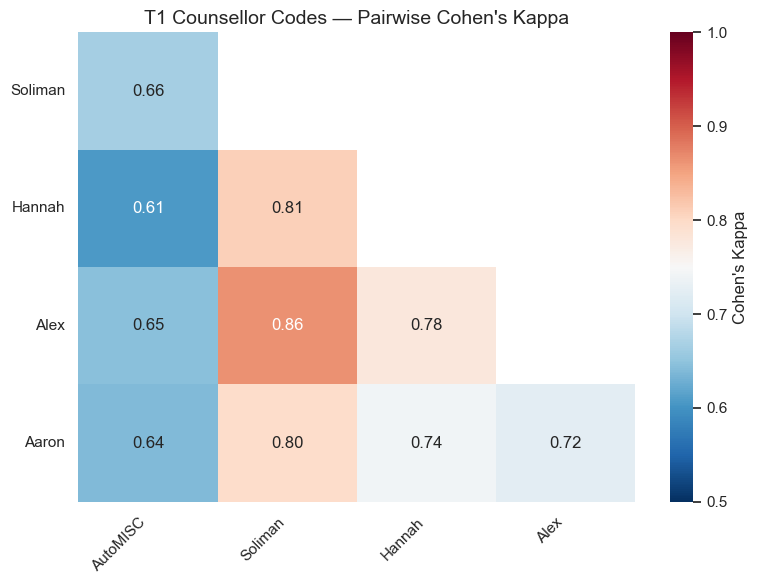

T1 counsellor: Agreement on 182 out of 322 datapoints (56.52%)
Fleiss' Kappa (T1, counsellor): 0.727


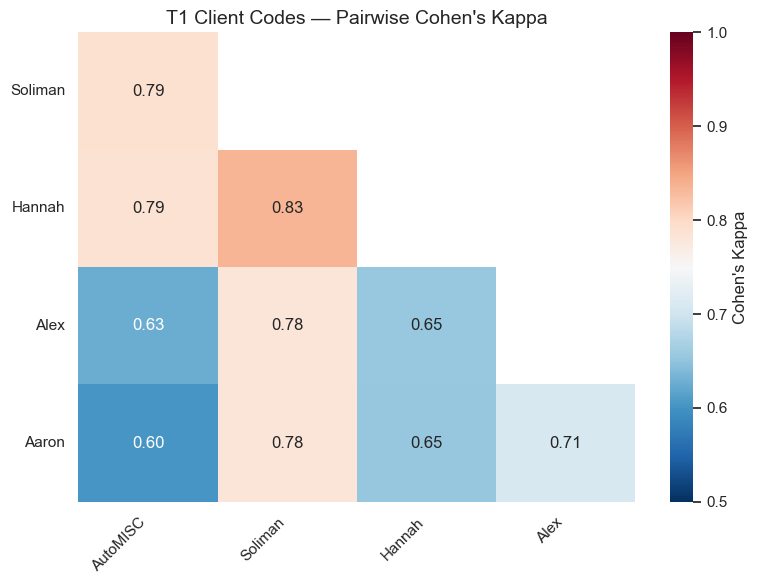

T1 client: Agreement on 84 out of 133 datapoints (63.16%)
Fleiss' Kappa (T1, client): 0.721


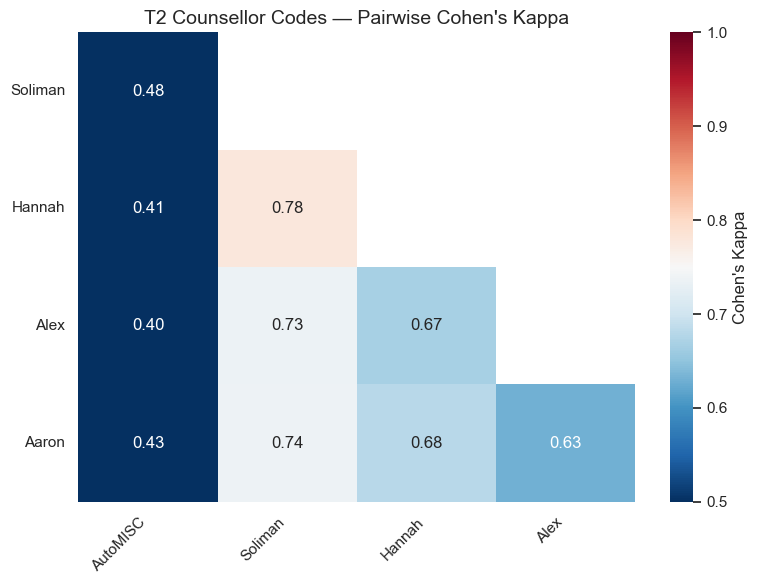

T2 counsellor: Agreement on 112 out of 322 datapoints (34.78%)
Fleiss' Kappa (T2, counsellor): 0.592


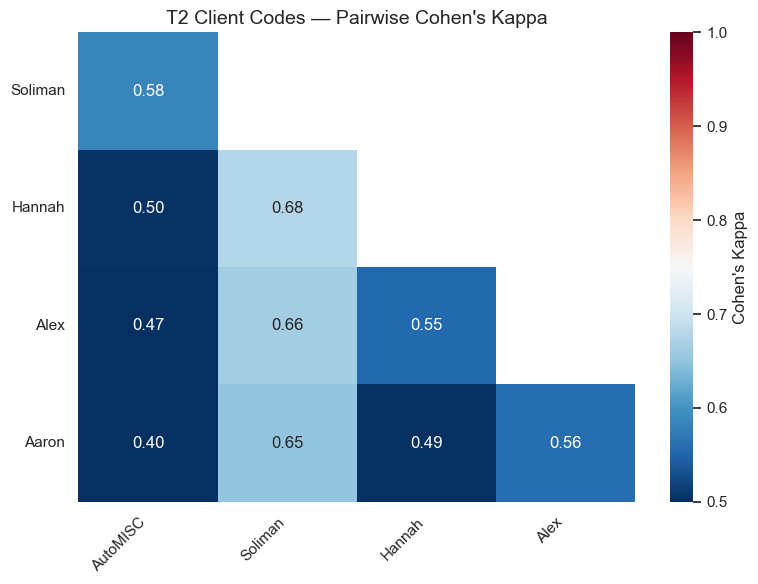

T2 client: Agreement on 54 out of 133 datapoints (40.60%)
Fleiss' Kappa (T2, client): 0.552
[2, 4, 9, 14, 15, 19, 20, 24, 25, 34, 35, 40, 41, 50, 51, 53, 54, 57, 59, 64, 65, 66, 69, 70, 71, 72, 73, 74, 79, 80, 89, 91, 93, 94, 95, 101, 104, 105, 114, 115, 129, 141, 147, 158, 161, 169, 170, 173, 174, 176, 178, 181, 182, 195, 197, 200, 206, 211, 215, 216, 218, 220, 222, 229, 240, 244, 245, 247, 256, 257, 262, 263, 267, 270, 271, 277, 278, 283, 288, 289, 292, 293, 297, 302, 311, 312, 313, 316, 320, 325, 326, 327, 331, 332, 333, 336, 337, 338, 339, 341, 345, 346, 347, 350, 355, 359, 361, 363, 366, 367, 368, 369, 372, 374, 377, 378, 379, 386, 390, 392, 393, 397, 405, 410, 411, 414, 422, 426, 427, 431, 432, 437, 442, 443, 446, 447, 448, 450, 451, 452, 27, 28, 33, 38, 43, 48, 55, 63, 67, 76, 77, 127, 128, 133, 139, 149, 150, 160, 165, 185, 186, 190, 208, 209, 213, 217, 221, 227, 237, 238, 239, 255, 261, 285, 286, 299, 305, 310, 324, 329, 335, 343, 365, 404, 429, 430, 434, 435, 436, 2, 3, 4, 9,

,Prolific ID,Speaker,Volley (Cumulative),Utterance,T1 Label (AutoMISC),T2 Label (AutoMISC),T1 Label (Soliman),T2 Label (Soliman),T1 Label (Alex),T2 Label (Alex),T1 Label (Hannah),T2 Label (Hannah),T1 Label (Aaron),T2 Label (Aaron)
0,60dde1621f6e206dea63a7dd,counsellor,Hello!,Hello!,O,FI,O,FI,O,FI,O,FI,O,FI
1,60dde1621f6e206dea63a7dd,counsellor,Hello! How are you doing today?,How are you doing today?,Q,OQ,Q,OQ,Q,OQ,Q,OQ,Q,OQ
2,60dde1621f6e206dea63a7dd,counsellor,Hello! How are you doing today? I'm really gla...,I'm really glad you chose to spend some time h...,CRL,AF,O,FI,O,FI,O,FI,O,FI
3,60dde1621f6e206dea63a7dd,counsellor,Hello! How are you doing today? I'm really gla...,Shall we start by talking a bit about how thin...,Q,OQ,Q,CQ,Q,CQ,Q,CQ,Q,CQ
4,60dde1621f6e206dea63a7dd,counsellor,Hello! How are you doing today? I'm really gla...,"Whatever's on your mind, feel free to share.",Q,OQ,CRL,EC,O,FI,O,FI,O,FI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,59cb95053306be000195be2e,counsellor,Thank you for sharing your thoughts with me to...,It seems there's a strong pull between the dou...,CRL,CR,SRL,SR,SRL,SR,SRL,SR,SRL,SR
451,59cb95053306be000195be2e,counsellor,Thank you for sharing your thoughts with me to...,You've talked about wanting to give it a try a...,CRL,AF,SRL,SR,SRL,SR,SRL,SR,SRL,SR
452,59cb95053306be000195be2e,counsellor,Thank you for sharing your thoughts with me to...,"Thank you again for this conversation, and whe...",O,FI,CRL,EC,CRL,EC,SRL,SR,CRL,SU
453,59cb95053306be000195be2e,counsellor,Thank you for sharing your thoughts with me to...,Would you like to continue the conversation?,Q,CQ,Q,CQ,Q,CQ,Q,CQ,Q,CQ


In [5]:
from itertools import product
# df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_first10.csv", nrows=366)
rows_to_skip = list(range(1, 367))
df = pd.read_csv("MIV6.3A_automiscv0.2_second5.csv", skiprows=rows_to_skip)
# df = pd.read_csv("test_10.csv", skiprows=rows_to_skip)

raters = ["AutoMISC", "Soliman", "Hannah", "Alex", "Aaron"]
# raters = ["Soliman", "Hannah", "Alex", "Aaron"]
# raters = ["Annotator 1", "Annotator 2"]

disagreement_rows = []
for tier, speaker in product(["T1", "T2"], ["counsellor", "client"]):
    _, dr = plot_pairwise_kappa_heatmap(df, raters, tier=tier, speaker=speaker)
    disagreement_rows.extend(dr)

print(disagreement_rows)
disagreement_indices = sorted(set(disagreement_rows))
disagreement_df = df.loc[disagreement_indices].copy()
disagreement_df = disagreement_df.reset_index(drop=True)

disagreement_df["Utterance #"] = disagreement_indices

disagreement_df.to_csv("disagreement_rows.csv", index=False)

df


## Visualizing Trajectories

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# === Label mappings and categories ===
T1_client_label_mapping = {'C': 1, 'N': 0, 'S': -1}
T2_client_labels = ['TS-', 'AC-', 'C-', 'N-', 'R-', 'AB-', 'D-', 'O-', 'N',
                    'O+', 'D+', 'AB+', 'R+', 'N+', 'C+', 'AC+', 'TS+']
T2_client_label_mapping = {label: np.linspace(-1, 1, len(T2_client_labels))[i]
                           for i, label in enumerate(T2_client_labels)}

T2_preparatory_change = ['D+', 'AB+', 'R+', 'N+']
T2_mobilizing_change = ['C+', 'AC+', 'TS+']
T2_preparatory_sustain = ['D-', 'AB-', 'R-', 'N-']
T2_mobilizing_sustain = ['C-', 'AC-', 'TS-']

simplify_labels = {'AB+': 'A+', 'AC+': 'A+', 'AB-': 'A-', 'AC-': 'A-'}

counsellor_labels = ['IMI', 'O', 'SRL', 'IMC', 'Q', 'CRL']

import pandas as pd
import hashlib
import hmac

# === Reverse Anonymization Setup ===
SECRET_KEY = "DIGITAL_HEALTH_2025"  # Replace with your actual secret key

def anonymize_id(participant_id: str, secret_key: str = SECRET_KEY) -> str:
    key_bytes = secret_key.encode('utf-8')
    pid_bytes = participant_id.encode('utf-8')
    hashed = hmac.new(key_bytes, pid_bytes, hashlib.sha256)
    return hashed.hexdigest()

# === Load Ruler Data ===
ruler_df = pd.read_csv("data.csv")

def get_confidence_scores(original_id: str) -> tuple:
    # anon_id = anonymize_id(original_id)
    anon_id = original_id
    match = ruler_df[ruler_df["Participant id"] == anon_id]
    if match.empty:
        return None, None, None  # No match found
    pre = match["pre_confidence"].values[0]
    post = match["post_confidence"].values[0]
    delta = post - pre
    return pre, post, delta

# === Compute client momentum ===
def compute_client_momentum(label_series, alpha=0.1, tier='T1'):
    momentum = np.zeros_like(label_series, dtype=float)

    for i in range(1, len(label_series)):
        label = label_series.iloc[i]

        # Carry forward if label is missing
        if pd.isna(label):
            momentum[i] = momentum[i - 1]
            continue

        prev = momentum[i - 1]

        if tier == "T1":
            if label == 'C':
                momentum[i] = prev + alpha
            elif label == 'S':
                momentum[i] = prev - alpha
            else:
                momentum[i] = prev * (1 - alpha)
        else:  # T2 logic
            if label in T2_mobilizing_change:
                delta = 2 * alpha
            elif label in T2_preparatory_change:
                delta = alpha
            elif label in T2_preparatory_sustain:
                delta = -alpha
            elif label in T2_mobilizing_sustain:
                delta = -2 * alpha
            else:
                delta = 0

            # Apply delta or decay
            if delta != 0:
                momentum[i] = prev + delta
            else:
                momentum[i] = prev * (1 - alpha)

    return momentum

# === Prepare utterance dataframe ===
def prepare_utterance_labels(df, rater="Soliman", tier="T1"):
    t1_col, target_col = f"T1 Label ({rater})", f"{tier} Label ({rater})"
    df_subset = df[['Prolific ID', 'Volley #', 'Utterance #', 'Speaker', t1_col, target_col]].copy()
    df_subset['Label'] = np.where(df_subset['Speaker'] == 'counsellor', df_subset[t1_col], df_subset[target_col])
    df_subset.drop(columns=[t1_col, target_col], inplace=True)

    # Multi-label binary flags for counsellor codes
    def encode_labels(group):
        return {label: int(label in group['Label'].values) for label in counsellor_labels}
    utterance_labels = df_subset.groupby(['Prolific ID', 'Utterance #'], sort=False).apply(encode_labels).apply(pd.Series).reset_index()

    client_mapping = T1_client_label_mapping if tier == "T1" else T2_client_label_mapping
    client_codes = df_subset.groupby(['Prolific ID', 'Utterance #'])\
        .apply(lambda g: client_mapping.get(g[g['Speaker'] == 'client']['Label'].iloc[0], np.nan)
               if not g[g['Speaker'] == 'client'].empty else np.nan).reset_index(name='Client Code')

    utterance_labels = utterance_labels.merge(client_codes, on=['Prolific ID', 'Utterance #'], how='left')
    meta = df_subset[['Prolific ID', 'Utterance #', 'Volley #', 'Speaker', 'Label']].drop_duplicates()
    utterance_labels = utterance_labels.merge(meta, on=['Prolific ID', 'Utterance #'], how='left')
    utterance_labels["Volley #"] = utterance_labels.groupby("Prolific ID")["Volley #"]\
        .rank(method="dense").astype(int) - 1

    return utterance_labels, counsellor_labels

# === Plotting function ===
def plot_utterance_labels(prolific_id, df, counsellor_labels, rater, tier="T1", show_counsellor=True, alpha=0.1):
    user_data = df[df["Prolific ID"] == prolific_id].sort_values("Utterance #")
    utterances = user_data["Utterance #"].values
    volleys = user_data["Volley #"].values
    speakers = user_data["Speaker"].values
    client_codes = user_data["Client Code"].values
    client_labels = user_data["Label"].values
    labels = user_data.drop(columns=["Prolific ID", "Utterance #", "Volley #", "Client Code", "Speaker", "Label"]).values if show_counsellor else None

    fig, ax1 = plt.subplots(figsize=(18, 6))

    if tier == "T2":
        norm = lambda val: (val + 1.1) / 2.2
        midpoint = lambda a, b: (T2_client_label_mapping[a] + T2_client_label_mapping[b]) / 2
        bands = [
            (0.0, norm(midpoint('N-', 'C-')), "#FF4500"),
            (norm(midpoint('N-', 'C-')), norm(midpoint('O-', 'D-')), "#FFA07A"),
            (norm(midpoint('O-', 'D-')), norm(midpoint('O+', 'D+')), "#EEEEEE"),
            (norm(midpoint('O+', 'D+')), norm(midpoint('N+', 'C+')), "#FFA07A"),
            (norm(midpoint('N+', 'C+')), 1.0, "#FF4500"),
        ]
    for i, (utt, speaker) in enumerate(zip(utterances, speakers)):
        if speaker != "client":
            ax1.axvspan(utt, utt + 1, color="#ADD8E6", alpha=0.4)
        elif tier == "T2":
            if show_counsellor == False:
                ax1.axvspan(utt, utt+1, color="#FFA07A", alpha=0.4)

                # for ymin, ymax, color in bands:
                #     ax1.axvspan(utt, utt + 1, ymin=ymin, ymax=ymax, color=color, alpha=0.3)

            else:
                ax1.axvspan(utt, utt+1, color="#FFCCCC", alpha=0.4)

    # === Left axis ===
    if show_counsellor:
        for i, (utt, speaker, label_set) in enumerate(zip(utterances, speakers, labels)):
            if speaker == 'counsellor':
                for pos in [j for j, v in enumerate(label_set) if v == 1]:
                    ax1.add_patch(plt.Rectangle((utt, pos), 1, 1))
        yticks = [i + 0.5 for i in range(len(counsellor_labels))]
        ax1.set_yticks(yticks)
        ax1.set_yticklabels(counsellor_labels, fontsize=10)
        ax1.set_ylim(0, len(counsellor_labels))  # Explicit limit
        for i in range(1, len(counsellor_labels)):
            ax1.axhline(i, linestyle='--', linewidth=0.5, color='gray', zorder=0)
        ax1.set_ylabel(f"T1 Counsellor Labels ({rater})")
    else:
        # Set consistent y-limits, even if labels are hidden
        ax1.set_ylim(-1.1, 1.1)
        ytick_vals = list(T2_client_label_mapping.values()) if tier == "T2" else [-1, 0, 1]
        ytick_labels = [simplify_labels.get(lbl, lbl) for lbl in T2_client_labels] if tier == "T2" else ["S", "N", "C"]
        ax1.set_yticks(ytick_vals)
        ax1.set_yticklabels(ytick_labels, fontsize=8)
        ax1.set_ylabel(f"{tier} Client Labels ({rater})")

    # === X-axis ===
    volley_starts = [utterances[i] for i in range(len(utterances)) if i == 0 or volleys[i] != volleys[i - 1]]
    volley_labels = [volleys[i] for i in range(len(utterances)) if i == 0 or volleys[i] != volleys[i - 1]]
    for utt in utterances:
        ax1.axvline(utt, linestyle="--", linewidth=0.5, color="lightgray")
    ax1.set_xticks(volley_starts)
    ax1.set_xticklabels(volley_labels, fontsize=8)
    ax1.set_xlabel("Volley Number")
    ax1.set_title(f"Session Trajectory for {prolific_id}")
    ax1.grid(True, axis="x", linestyle="--", linewidth=0.5)

    # === Right y-axis ===
    ax2 = ax1.twinx()
    valid_client_indices = ~np.isnan(client_codes)
    ax2.hlines(client_codes[valid_client_indices],
               utterances[valid_client_indices],
               utterances[valid_client_indices] + 1,
               color='red', linewidth=5)

    ax2.plot(np.ravel(np.column_stack((utterances[valid_client_indices][:-1] + 1,
                                       utterances[valid_client_indices][1:]))),
             np.ravel(np.column_stack((client_codes[valid_client_indices][:-1],
                                       client_codes[valid_client_indices][1:]))),
             color='red', linewidth=1, label='Client Codes')

    label_series = pd.Series(client_labels[valid_client_indices], index=np.arange(len(client_labels))[valid_client_indices])
    momentum = compute_client_momentum(label_series, alpha=alpha, tier=tier)
    # ax2.plot(utterances[valid_client_indices] + 1, momentum, color='purple', linewidth=2, label='Client Momentum')

    if show_counsellor:
        # ax2.set_yticks([])
        ax2.set_yticks(list(T2_client_label_mapping.values()))
        ax2.set_yticklabels([simplify_labels.get(lbl, lbl) for lbl in T2_client_labels], fontsize=8)
        ax2.set_ylim(-1.1, 1.1)
        ax2.set_ylabel(f"{tier} Client Labels ({rater})")
    else:
        if tier == "T1":
            ax2.set_yticks([-1, 0, 1])
            ax2.set_yticklabels(["S", "N", "C"])
        else:
            ax2.set_yticks([])
        ax2.set_ylim(-1.1, 1.1)
        def midpoint(a, b):
            return (T2_client_label_mapping[a] + T2_client_label_mapping[b]) / 2

        mid_Oplus_Dplus = midpoint('O+', 'D+')
        mid_Ominus_Dminus = midpoint('O-', 'D-')
        mid_Nminus_Cminus = midpoint('N-', 'C-')
        mid_Nplus_Cplus = midpoint('N+', 'C+')

        # Draw horizontal lines at these computed midpoints
        ax2.axhline(mid_Oplus_Dplus, color='gray', linestyle='--', linewidth=0.8)
        ax2.axhline(mid_Ominus_Dminus, color='gray', linestyle='--', linewidth=0.8)
        ax2.axhline(mid_Nminus_Cminus, color='gray', linestyle='--', linewidth=0.8)
        ax2.axhline(mid_Nplus_Cplus, color='gray', linestyle='--', linewidth=0.8)
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)


    legend_elements = [
        Line2D([0], [0], color='red', linewidth=5, label='Client Codes'),
        # Line2D([0], [0], color='purple', linewidth=2, label='Client Momentum'),
        # Patch(facecolor='#FFA07A', alpha=0.4, edgecolor='lightgray', label='Preparatory Change/Sustain Talk'),
        # Patch(facecolor='#FF4500', alpha=0.4, edgecolor='lightgray', label='Mobilizing Change/Sustain Talk')
        
    ]

    # Add confidence scores if available
    pre, post, delta = get_confidence_scores(prolific_id)
    if pre is not None:
        conf_label = f"Confidence: Pre={pre}, Post={post}, $\Delta$={delta:+}"
        legend_elements.append(Line2D([0], [0], color='black', linewidth=0, label=conf_label))

    ax2.legend(handles=legend_elements, loc="best")
    plt.tight_layout()
    # plt.savefig(f"{prolific_id}_trajectory_{tier}.png")
    plt.show()

In [7]:
df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_first10.csv")
# df = pd.read_csv("HLQC_nolabel_aggregated_results_t2.csv")

# Choose rater and tier (e.g. Soliman, T1 or T2)
rater = "AutoMISC"
tier = "T2"

# Prepare and plot
utterance_labels, counsellor_labels = prepare_utterance_labels(df, rater=rater, tier=tier)

for pid in utterance_labels["Prolific ID"].unique()[0:10]:
    plot_utterance_labels(pid, utterance_labels, counsellor_labels, rater=rater, tier=tier, show_counsellor=False)

FileNotFoundError: [Errno 2] No such file or directory: 'MIV6.3A_automiscv0.2_aggregated_results_t2_first10.csv'

## Compare HLQC

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import plotly.io as pio

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.cell .rendered_html { font-size: 12px; } div.text_cell_render { font-size: 12px; }</style>"))
pio.renderers.default = "browser"
plt.rc("text", usetex=True)
# plt.rc("font", family="cm")
plt.rc("font", family="serif")
pd.set_option("display.max_colwidth", None)
plt.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"  # Better serif math fonts

# Load your data sources
data1 = pd.read_csv("../analysis/HLQC_HI_summary_results.csv")
data2 = pd.read_csv("../analysis/HLQC_LO_summary_results.csv")
data3 = pd.read_csv("../analysis/MIV6.3A_summary_results.csv")
# data4 = pd.read_csv("HLQC_nolabel_summary_results_t2_high.csv")
# data5 = pd.read_csv("HLQC_nolabel_summary_results_t2_low.csv")
# data6 = pd.read_csv("2024-11-19-MIV6.1B_parsed_summary_results_t2.csv")

# Manually exclude a single data point
# data1 = data1[data1['Conversation ID'] != 'high_052']
data4 = data4[data4['prolific_id'] != 'high_052']

data3['%MIC'] = np.where((data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN']) > 0,
                            100*((data3['MICO'] + data3['R'] + data3['Q'])/ (data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN'])), 0)

# group codes and compute %MIC for v2 ones
for data in [data4, data5, data6]:
    data['MICO'] = data['AF'] + data['ADP'] + data['EC'] + data['RCP'] + data['SU'] + data['OQ'] + data['SR'] + data['CR']
    data['MIIN'] = data['ADW'] + data['CO'] + data['DI'] + data['RCW'] + data['WA']
    data['%MIC'] = np.where((data['MICO'] + data['MIIN']) > 0,
                            100 * (data['MICO'] / (data['MICO'] + data['MIIN'])), 0)
    data['R:Q'] = np.where((data['OQ'] + data['CQ']) > 0,
                           (data['SR'] + data['CR']) / (data['OQ'] + data['CQ']), 0)
    data['C:S'] = np.where(data['S'] > 0, data['C'] / data['S'], 0)


columns = ['%MIC', 'R:Q', 'C:S']
# datasets = ['MIV6.3A_v0.1', 'HLQC_HI_v0.1', 'HLQC_HI_v0.2', 'HLQC_LO_v0.1', 'HLQC_LO_v0.2']
# data_sources = [data3, data1, data4, data2, data5]
datasets = ['MIV6.3A_v0.1', 'MIV6.3B_v0.2', 'HLQC_HI_v0.2',  'HLQC_LO_v0.2']
data_sources = [data3, data6, data4, data5]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Create a table to store statistics
statistics_table = []

# Function to compute summary statistics
def compute_statistics(data):
    stats = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "Min": np.min(data),
        "Max": np.max(data),
        "IQR": np.percentile(data, 75) - np.percentile(data, 25),
        "25th Percentile": np.percentile(data, 25),
        "75th Percentile": np.percentile(data, 75),
        "Std Dev": np.std(data),
    }
    return stats

# Plot each column in a separate subplot
for i, col in enumerate(columns):
    if col == 'C:S':
        current_data = [
            100*(data['C'] / (data['C'] + data['S'])).where(data['C'] + data['S'] > 0, 0)
            for data in data_sources
        ]
    else:
        current_data = [data[col] for data in data_sources]
    
    # Create the violin plot
    vp = axes[i].violinplot(current_data, showmeans=False, showmedians=False, widths=0.8)
    
    # Customize the filled bodies
    # colors = ['red', 'green', 'limegreen', 'blue', 'cornflowerblue']
    colors = ['red', 'orange', 'limegreen', 'cornflowerblue']

    for j, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[j])
        pc.set_edgecolor(colors[j])  # Set outline color
        pc.set_alpha(0.5)
    
    # Customize mean, min, max, and bar colors
    for partname in ('cmins', 'cmaxes', 'cbars'):
        if partname in vp: 
            vp[partname].set_alpha(0)
    
    bp = axes[i].boxplot(current_data, positions=range(1, len(datasets) + 1), widths=0.3, patch_artist=True, 
                     showmeans=True, meanline=False, flierprops={'marker': 'o', 'color': 'black'}, 
                     meanprops={'marker': '^', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})

    for box in bp['boxes']:
        box.set(color='black', linewidth=1)  # Box outline
        box.set(facecolor='white')             # Box fill

    for whisker in bp['whiskers']:
        whisker.set(color='black', linewidth=1)  # Whiskers

    for cap in bp['caps']:
        cap.set(color='black', linewidth=1)  # Caps

    for median in bp['medians']:
        median.set(color='red', linewidth=2)  # Median line

    for mean in bp['means']:
        mean.set(marker='^', color='black', markersize=8)  # Mean triangle marker

    # Compute and store statistics for each dataset
    for dataset, dataset_name in zip(current_data, datasets):
        stats = compute_statistics(dataset)
        stats["Dataset"] = dataset_name
        stats["Metric"] = col
        statistics_table.append(stats)
    
    # Set x-axis and y-axis labels
    axes[i].set_xticks(range(1, len(datasets) + 1))
    axes[i].set_xticklabels(datasets)
    col = col.replace("%MIC", "\%MIC")
    col = col.replace("C:S", "\%CT")
    axes[i].set_title(f"Violin Plot for {col}")
    axes[i].set_ylabel("Values" if i == 0 else "")  # Add y-axis label only to the first plot
    if i == 1:
        legend_elements = [
            Line2D([0], [0], marker='^', color='black', markersize=8, linestyle='None', label='Mean'),
            Line2D([0], [0], color='red', linewidth=2, label='Median')
        ]
        axes[i].legend(handles=legend_elements, loc='upper right')
        axes[i].set_ylim(-0.5, 10.5)

# Convert statistics into a DataFrame
stats_df = pd.DataFrame(statistics_table)
stats_df = stats_df[['Dataset', 'Metric', 'Mean', 'Median', 'Min', 'Max', 'IQR', '25th Percentile', '75th Percentile', 'Std Dev']]

# Save to a CSV file (optional)
stats_df.to_csv("violin_plot_statistics.csv", index=False)

# Pretty print the statistics table to the console
pd.set_option('display.width', 1000)
with pd.option_context('display.float_format', '{:,.2f}'.format):  # Format floats with 2 decimal places
    print(stats_df)
# Adjust layout and show plot
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../analysis/HLQC_HI_summary_results.csv'

          Dataset Metric  Mean  Median   Min    Max   IQR  25th Percentile  75th Percentile  Std Dev
0         HLQC_LO   %MIC 48.11   51.72  0.00 100.00 41.84            25.66            67.50    27.92
1         HLQC_HI   %MIC 92.38   95.82 50.00 100.00 10.96            89.04           100.00     9.72
2  \textit{MIBot}   %MIC 98.09  100.00 82.76 100.00  2.40            97.60           100.00     3.62
3         HLQC_LO    R:Q  0.70    0.33  0.00   9.00  0.65             0.08             0.73     1.27
4         HLQC_HI    R:Q  2.33    1.15  0.00  62.00  1.16             0.73             1.89     5.65
5  \textit{MIBot}    R:Q  1.26    1.25  0.40   2.56  0.46             1.00             1.46     0.34
6         HLQC_LO    C:S 23.24   12.50  0.00 100.00 38.89             0.00            38.89    29.53
7         HLQC_HI    C:S 52.70   56.33  0.00 100.00 40.45            34.14            74.59    28.20
8  \textit{MIBot}    C:S 59.44   64.71  0.00 100.00 38.37            42.11            80.48

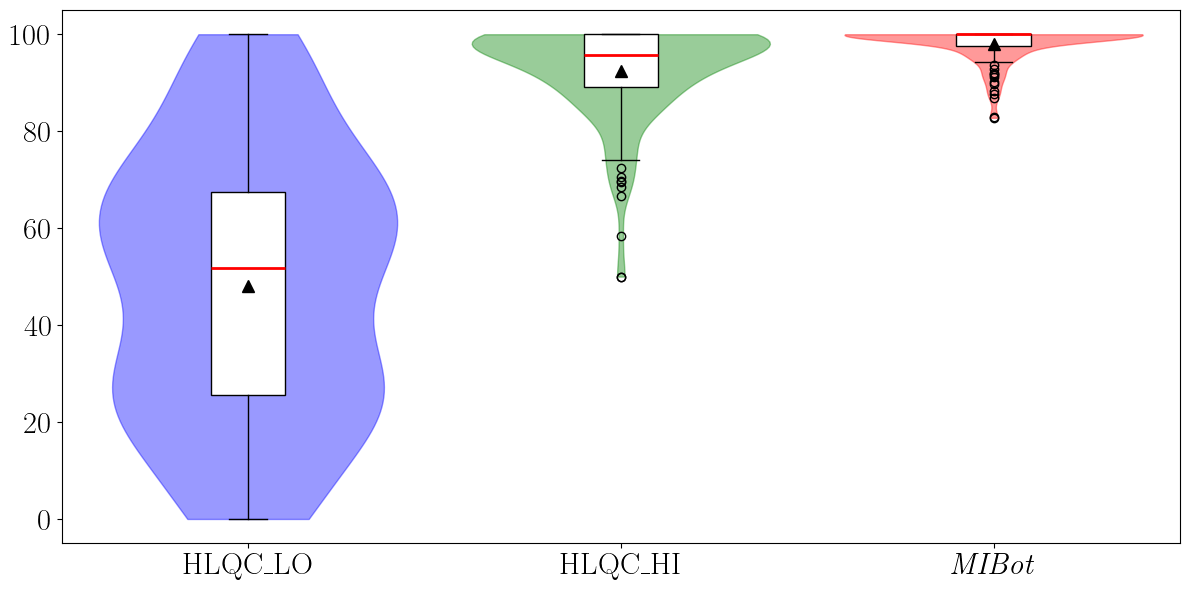

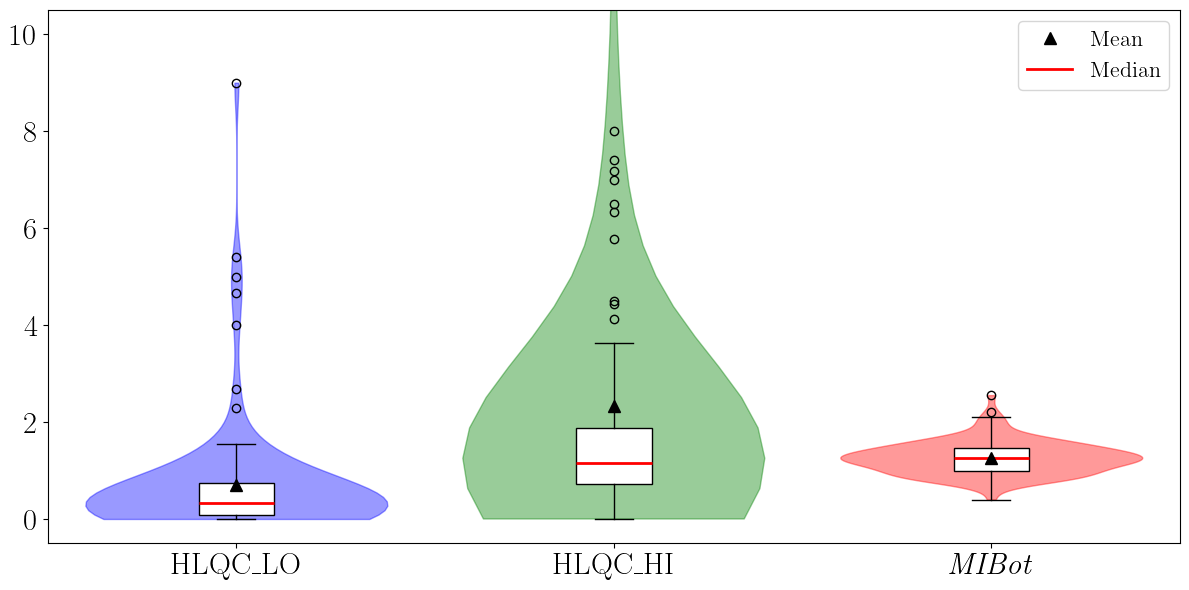

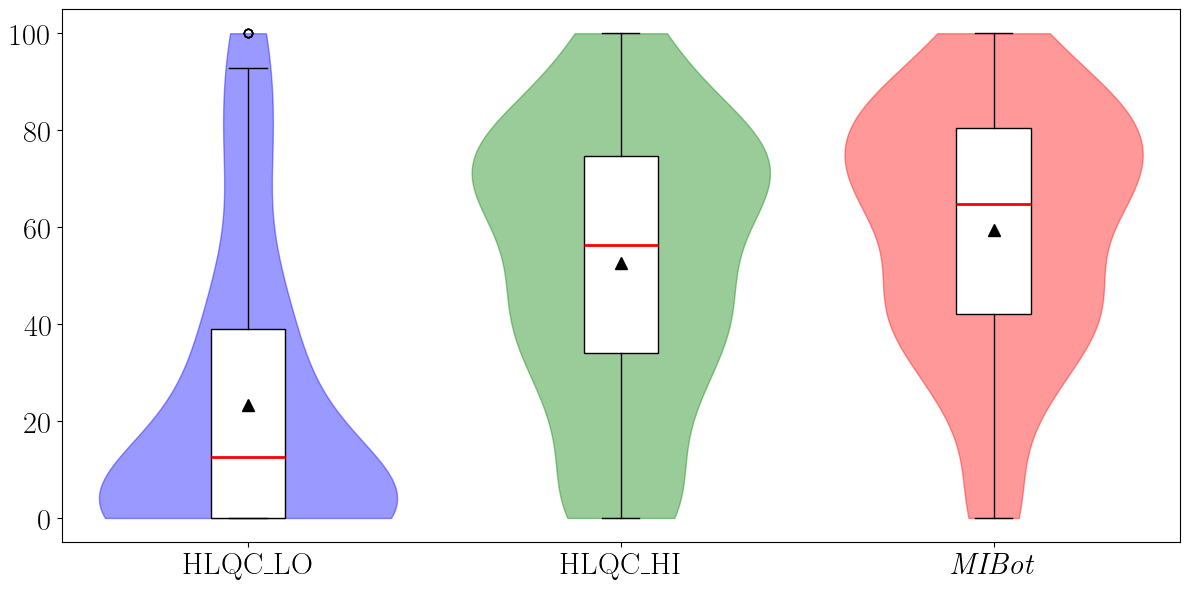

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import plotly.io as pio
from matplotlib.lines import Line2D
import re


display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.cell .rendered_html { font-size: 12px; } div.text_cell_render { font-size: 12px; }</style>"))
pio.renderers.default = "browser"
plt.rc("text", usetex=True)
plt.rc("font", family="cm")
pd.set_option("display.max_colwidth", None)

# Load your data sources
data1 = pd.read_csv("../analysis/HLQC_HI_summary_results.csv")
data2 = pd.read_csv("../analysis/HLQC_LO_summary_results.csv")
data3 = pd.read_csv("../analysis/MIV6.3A_summary_results.csv")

data3['%MIC'] = np.where((data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN']) > 0,
                            100*((data3['MICO'] + data3['R'] + data3['Q'])/ (data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN'])), 0)


# Extract the columns for analysis
# columns = ['%MIC', 'R:Q', 'C:S']
datasets = ['HLQC_LO', 'HLQC_HI', r'\textit{MIBot}']
data_sources = [data2, data1, data3]
columns = ['%MIC', 'R:Q', 'C:S']

# Create a table to store statistics
statistics_table = []

# Function to compute summary statistics
def compute_statistics(data):
    stats = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "Min": np.min(data),
        "Max": np.max(data),
        "IQR": np.percentile(data, 75) - np.percentile(data, 25),
        "25th Percentile": np.percentile(data, 25),
        "75th Percentile": np.percentile(data, 75),
        "Std Dev": np.std(data),
    }
    return stats

# Plot each column in a separate subplot
for i, col in enumerate(columns):

    fig, ax = plt.subplots(figsize=(12, 6))
    if col == 'C:S':
        current_data = [
            100*(data['C'] / (data['C'] + data['S'])).where(data['C'] + data['S'] > 0, 0)
            for data in data_sources
        ]
    else:
        current_data = [data[col] for data in data_sources]

    if col == "R:Q":
        ax.set_ylim(-0.5, 10.5)  # Truncate R:Q violin plot at y=10
    
    
    # Create the violin plot
    vp = ax.violinplot(current_data, showmeans=False, showmedians=False, widths=0.8)

    for partname in ['cmins', 'cmaxes', 'cbars']:
        if partname in vp:
            vp[partname].set_alpha(0)
    
    # Customize the filled bodies
    # colors = ['red', 'green', 'lightgreen', 'blue', 'lightblue']
    colors = ['blue', 'green', 'red']

    for j, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[j])
        pc.set_edgecolor(colors[j])  # Set outline color
        pc.set_alpha(0.4)
    
    # Customize mean, min, max, and bar colors
    # for partname in ('cmeans', 'cmeins', 'cmaxes', 'cbars'):
    #     vp[partname].set_edgecolor(colors[j])
    #     vp[partname].set_linewidth(1.5)
    # vp['cmeans'].set_color('black')
    # vp['cmedians'].set_color('red')


        # Overlay box plot on the violin plot
    bp = ax.boxplot(current_data, positions=range(1, len(datasets) + 1), widths=0.2, patch_artist=True, 
                        showmeans=True, meanline=False, flierprops={'marker': 'o', 'color': 'black'}, 
                        meanprops={'marker': '^', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})

    # Customize the box plots
    for box in bp['boxes']:
        box.set(color='black', linewidth=1)  # Box outline
        box.set(facecolor='white')             # Box fill

    for whisker in bp['whiskers']:
        whisker.set(color='black', linewidth=1)  # Whiskers

    for cap in bp['caps']:
        cap.set(color='black', linewidth=1)  # Caps

    for median in bp['medians']:
        median.set(color='red', linewidth=2)  # Median line

    for mean in bp['means']:
        mean.set(marker='^', color='black', markersize=8)  # Mean triangle marker

    # Add legend on the second graph only
    legend_elements = [
        Line2D([0], [0], marker='^', color='black', markersize=8, linestyle='None', label='Mean'),
        Line2D([0], [0], color='red', linewidth=2, label='Median')
    ]

    # Add the custom legend to the second graph only
    if i == 1:
        ax.legend(handles=legend_elements, loc='upper right', fontsize=16)
    
    # Compute and store statistics for each dataset
    for dataset, dataset_name in zip(current_data, datasets):
        stats = compute_statistics(dataset)
        stats["Dataset"] = dataset_name
        stats["Metric"] = col
        statistics_table.append(stats)
    
    # Set x-axis and y-axis labels
    ax.set_xticks(range(1, len(datasets) + 1))
    # axes[i].set_xticklabels(datasets)
    ax.set_xticklabels(datasets, fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    col = col.replace("%MIC", "\%MIC")
    col = col.replace("C:S", "\%CT")
    col_filename = re.sub(r'[^a-zA-Z]', '', col).lower()
    plt.tight_layout()
    plt.savefig(f"{col_filename}.png", dpi=600)
    
    # axes[i].set_title(f"Violin Plot for {col}")
    # axes[i].set_ylabel("Values" if i == 0 else "")  # Add y-axis label only to the first plot

# Convert statistics into a DataFrame
stats_df = pd.DataFrame(statistics_table)
stats_df = stats_df[['Dataset', 'Metric', 'Mean', 'Median', 'Min', 'Max', 'IQR', '25th Percentile', '75th Percentile', 'Std Dev']]

# Save to a CSV file (optional)
stats_df.to_csv("violin_plot_statistics.csv", index=False)

# Pretty print the statistics table to the console
pd.set_option('display.width', 1000)
with pd.option_context('display.float_format', '{:,.2f}'.format):  # Format floats with 2 decimal places
    print(stats_df)
# Adjust layout and show plot
plt.tight_layout()

plt.show()

# Predicting Delta Confidence

### First step: Simple linear regression

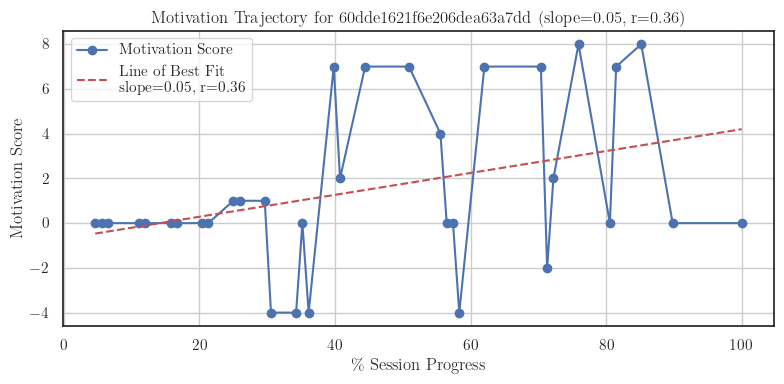

Pearson correlation: r = 0.27, p = 0.0036
                            OLS Regression Results                            
Dep. Variable:       delta_confidence   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     8.826
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00363
Time:                        12:38:11   Log-Likelihood:                -237.13
No. Observations:                 115   AIC:                             478.3
Df Residuals:                     113   BIC:                             483.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

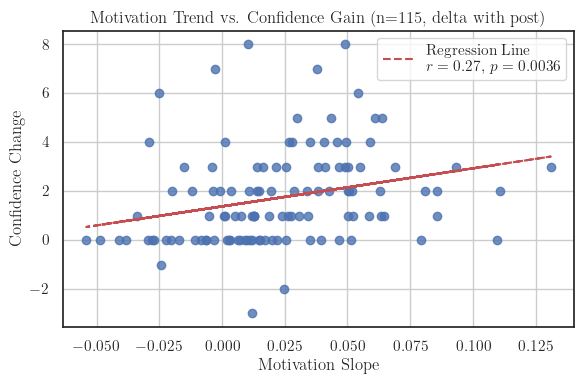

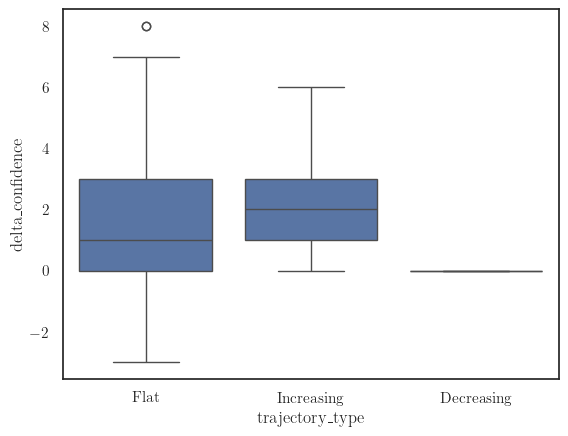

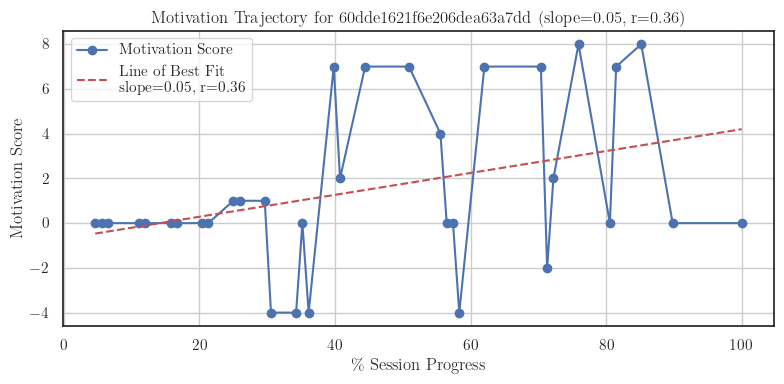

Pearson correlation: r = 0.26, p = 0.0083
                            OLS Regression Results                            
Dep. Variable:       delta_confidence   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     7.250
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00827
Time:                        12:38:11   Log-Likelihood:                -237.80
No. Observations:                 106   AIC:                             479.6
Df Residuals:                     104   BIC:                             484.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

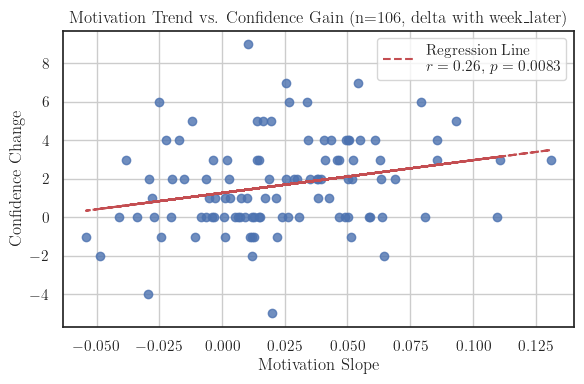

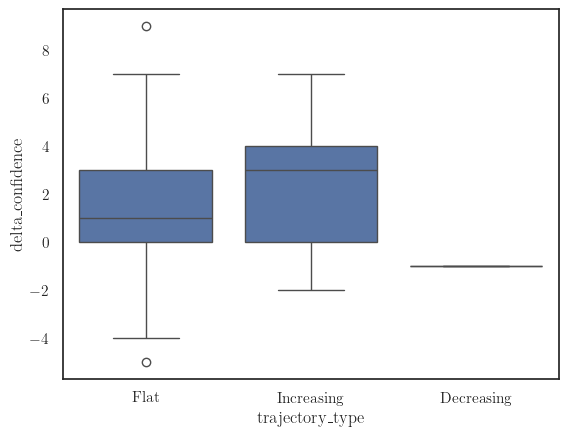

In [ ]:
from scipy.stats import linregress, pearsonr

def get_slope(session, pid, normalize=True, plot=False):
    client_utt = session[session["Speaker"] == "client"].copy()
    y = client_utt['score'].values
    
    if len(y) < 2: 
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    if normalize:
        full_indices = session.index
        client_indices = client_utt.index
        session_len = len(full_indices)
        x = [100* full_indices.get_loc(i) / (session_len - 1) for i in client_indices]
    else:
        x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    if plot:
        line = intercept + slope * np.array(x)
        plt.figure(figsize=(8, 4))
        plt.plot(x, y, 'o-', label='Motivation Score')
        plt.plot(x, line, 'r--', label=f'Line of Best Fit\nslope={slope:.2f}, r={r_value:.2f}')
        plt.xlabel('\% Session Progress' if normalize else 'Utterance Index')
        plt.ylabel('Motivation Score')
        plt.title(f'Motivation Trajectory for {pid} (slope={slope:.2f}, r={r_value:.2f})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return slope, intercept, r_value, p_value, std_err

def get_confidence_scores(prolific_id, delta_with) -> tuple:
    ruler_df = pd.read_csv("data.csv")
    match = ruler_df[ruler_df["Participant id"] == prolific_id]
    if match.empty:
        return None, None, None  # No match found
    pre = match["pre_confidence"].values[0]
    post = match[f"{delta_with}_confidence"].values[0]
    delta = post - pre
    return pre, post, delta

def linear_regression(df, delta_with="post"):
    label_to_score = {
        "TS-": -8, "AC-": -7, "C-": -6, 
        "N-": -5, "R-": -4, "AB-": -3, "D-": -2, 
        "O-": -1,
        "N": 0, 
        "O+": 1,
        "D+": 2, "AB+": 3, "R+": 4, "N+": 5, 
        "C+": 6, "AC+": 7, "TS+": 8, 
    }

    df = df.copy()
    df['score'] = df['T2 Label (AutoMISC)'].map(label_to_score)

    slopes = []
    deltas = []

    group = list(df.groupby("Prolific ID", sort=False))

    for pid, session in group:
        plot = False if pid != '60dde1621f6e206dea63a7dd' else True
        slope, _, r_value, _, _ = get_slope(session, pid, normalize=True, plot=plot)
        pre, post, delta = get_confidence_scores(pid, delta_with)
        # print(f"{pid} → motivation slope: {slope} (r={r_value:.2f}) delta={delta:.2f}")
        if pd.isna(slope) or pd.isna(delta):
            # print('hm???')
            continue
        slopes.append(slope)
        deltas.append(delta)

    results = pd.DataFrame({
        'slope': slopes,
        'delta_confidence': deltas
    })

    r, p = pearsonr(results['slope'], results['delta_confidence'])
    print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

    from statsmodels.api import OLS, add_constant
    X = add_constant(results['slope'])
    y = results['delta_confidence']
    model = OLS(y, X).fit()
    print(model.summary())
    plt.figure(figsize=(6, 4))
    plt.scatter(results['slope'], results['delta_confidence'], alpha=0.8)
    pred_line = model.predict(X)
    plt.plot(results['slope'], pred_line, 'r--', label=f'Regression Line\n$r = {r:.2f}$, $p = {p:.4f}$')
    plt.xlabel('Motivation Slope')
    plt.ylabel(f'Confidence Change')
    plt.title(f'Motivation Trend vs. Confidence Gain (n={len(results)}, delta with {delta_with})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    def classify_trend(slope):
        if slope > 0.05:
            return 'Increasing'
        elif slope < -0.05:
            return 'Decreasing'
        else:
            return 'Flat'

    results['trajectory_type'] = results['slope'].apply(classify_trend)
    results.groupby('trajectory_type')['delta_confidence'].mean()
    import seaborn as sns
    sns.boxplot(x='trajectory_type', y='delta_confidence', data=results)


df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_lowconf.csv")

linear_regression(df, delta_with="post")
linear_regression(df, delta_with="week_later")

### Method 2: multiple regression on points

In [ ]:
# B-spline fitting

from skfda.representation.grid import FDataGrid
from sklearn.metrics import r2_score, mean_squared_error
import skfda
# from skfda.representation.grid.FDataGrid import concatenate
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.ml.regression import LinearRegression as FDARegression
# from skfda.misc.extrapolation import Extrapolation

def method2(df, method="pointwise", delta_with="post", n_interp=10, plot=False, plot_example=False):
    label_to_score = {
        "TS-": -8, "AC-": -7, "C-": -6, 
        "N-": -5, "R-": -4, "AB-": -3, "D-": -2, 
        "O-": -1,
        "N": 0, 
        "O+": 1,
        "D+": 2, "AB+": 3, "R+": 4, "N+": 5, 
        "C+": 6, "AC+": 7, "TS+": 8, 
    }
    df = df.copy()
    df['score'] = df['T2 Label (AutoMISC)'].map(label_to_score)

    group = list(df.groupby("Prolific ID", sort=False))

    fd_list = []
    deltas = []
    common_grid = np.linspace(0, 100, n_interp)

    for pid, session in group:
        client_utt = session[session["Speaker"] == "client"].copy()
        y = client_utt['score'].values
        full_indices = session.index
        client_indices = client_utt.index
        session_len = len(full_indices)
        x = [100* full_indices.get_loc(i) / (session_len - 1) for i in client_indices]
        y_interp = np.interp(common_grid, x, y, left=y[0], right=y[-1])
        if pid == '60dde1621f6e206dea63a7dd' and plot_example:
            plt.figure(figsize=(8, 4))
            plt.plot(x, y, 'o-', label='Motivation Score')
            plt.plot(common_grid, y_interp, 'o-', label='Interpolated Score')
            plt.xlabel('\% Session Progress')
            plt.ylabel('Motivation Score')
            plt.title(f'Motivation Trajectory for {pid} (k={n_interp})')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        # fd_grid = FDataGrid(data_matrix=[y], grid_points=[x], domain_range=(0.0, 100.0), extrapolation="bounds")
        if method == "bspline":
            fd_grid = FDataGrid(data_matrix=[y_interp], grid_points=[common_grid])
        elif method == "pointwise":
            fd_grid = y_interp
        pre, post, delta = get_confidence_scores(pid, delta_with)
        if pd.isna(delta):
            continue
        fd_list.append(fd_grid)

        deltas.append(delta)

    if method == "bspline":

        fd_all = skfda.concatenate(fd_list)

        model = FDARegression()
        basis = BSplineBasis(domain_range=(0, 100), n_basis=10, order=5)
        smoother = BasisSmoother(basis=basis, return_basis=True)
        fd_linear = smoother.fit_transform(fd_all)

        X_df = pd.DataFrame({"motivation": fd_linear})
        model.fit(X_df, pd.Series(deltas))

        y_pred = model.predict(X_df)

        # Coefficient function β(t)
        model.coef_[0].plot()
        plt.title(r"Coefficient Function $\beta$(t)")
        plt.xlabel("\% Session Progress")
        plt.ylabel("Weight on Motivation at t")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif method == "pointwise":
        X = np.vstack(fd_list)  # shape: (n_sessions, 50)
        y = np.array(deltas)   # shape: (n_sessions,)

        X_with_const = sm.add_constant(X)

        # Fit model
        model = sm.OLS(y, X_with_const).fit()

        # Print summary
        # print(model.summary())
        # r, p = pearsonr(model.fittedvalues, model.model.endog)
        # print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

        # model = LinearRegression()
        # model.fit(X, y)
        # y_pred = model.predict(X)
        # print(f"R²: {r2_score(y, y_pred):.3f}")
        # print(f"MSE: {mean_squared_error(y, y_pred):.3f}")

        # Plot the learned weights
        # plt.plot(common_grid, model.coef_)
        if plot:
            plt.plot(common_grid, model.params[1:], marker='o', label="Linear Coefficients")
            plt.title(f"Linear Coefficients Across Session (k={n_interp}, delta with {delta_with})")
            plt.xlabel("% Session Progress")
            plt.ylabel("Weight on Delta Confidence")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    return model.rsquared, model.f_pvalue, model.rsquared_adj 





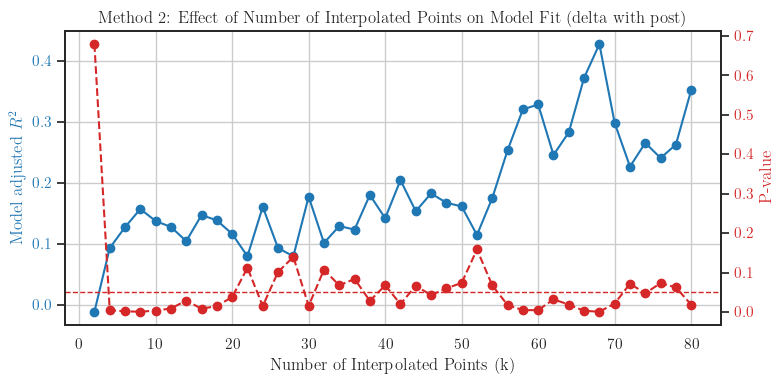

    n_chunks        r2   p-value    r2_adj
0          2  0.083039  0.678762 -0.010839
1          4  0.354100  0.004981  0.093583
2          6  0.416850  0.001844  0.127862
3          8  0.465488  0.000829  0.157561
4         10  0.462037  0.003868  0.137851
5         12  0.468971  0.009003  0.128162
6         14  0.463500  0.029175  0.104909
7         16  0.517005  0.008425  0.147669
8         18  0.524358  0.015230  0.139005
9         20  0.521260  0.037960  0.116757
10        22  0.507609  0.112300  0.080153
11        24  0.581160  0.015166  0.161146
12        26  0.547988  0.101629  0.093558
13        28  0.545885  0.139735  0.080125
14        30  0.622064  0.015576  0.177810
15        32  0.588340  0.107372  0.101933
16        34  0.617719  0.067683  0.129626
17        36  0.626795  0.083912  0.123890
18        38  0.668250  0.028466  0.180618
19        40  0.654483  0.067760  0.142521
20        42  0.695602  0.020396  0.204869
21        44  0.682424  0.066636  0.154029
22        4

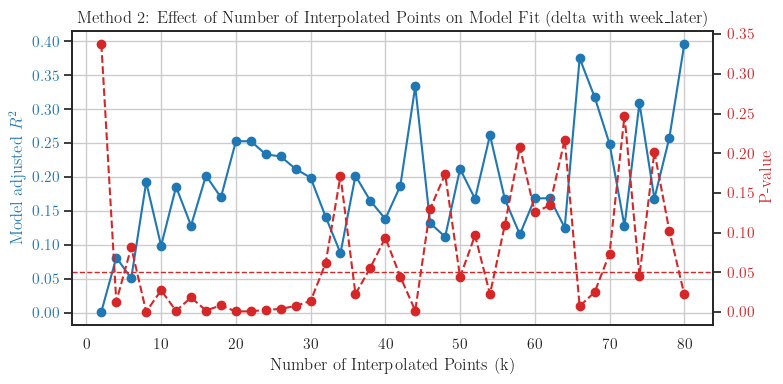

    n_chunks        r2   p-value    r2_adj
0          2  0.144485  0.337400  0.001864
1          4  0.341579  0.013104  0.081693
2          6  0.324485  0.081426  0.051066
3          8  0.504074  0.000282  0.192572
4         10  0.429937  0.027316  0.099040
5         12  0.528045  0.001398  0.185778
6         14  0.494851  0.018229  0.128705
7         16  0.569072  0.001820  0.202287
8         18  0.558980  0.008307  0.170209
9         20  0.628578  0.000591  0.252783
10        22  0.639981  0.000887  0.253077
11        24  0.639344  0.002553  0.233579
12        26  0.648875  0.003842  0.230495
13        28  0.643924  0.007703  0.212012
14        30  0.648402  0.013774  0.199272
15        32  0.628755  0.061147  0.142026
16        34  0.612147  0.171508  0.088140
17        36  0.684147  0.022584  0.202086
18        38  0.677688  0.055892  0.165036
19        40  0.671055  0.093595  0.138552
20        42  0.704814  0.044454  0.187079
21        44  0.774680  0.001724  0.333549
22        4

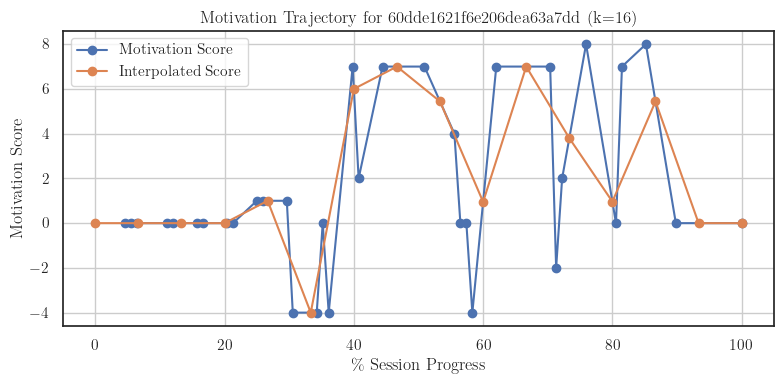

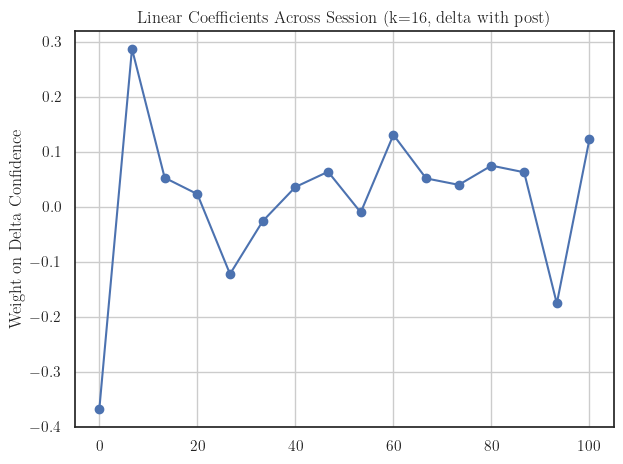

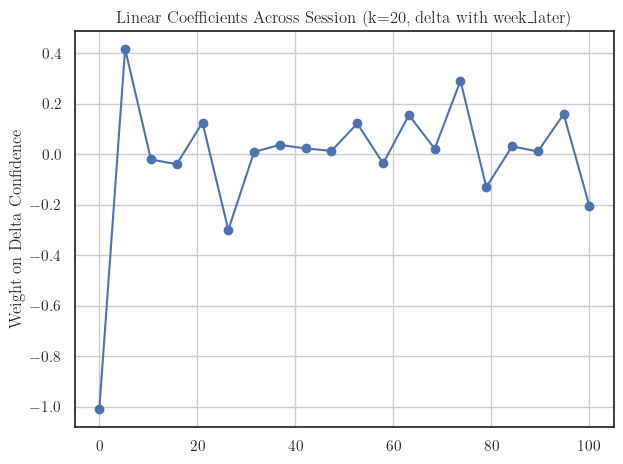

(np.float64(0.3951098129555114),
 np.float64(0.0005908988505590647),
 np.float64(0.2527827101215141))

In [ ]:
def find_n_m2(nlist, delta_with):
    results = []
    for n in nlist:
        r2, p, r2_adj = method2(df, method="pointwise", delta_with=delta_with, n_interp=n)
        results.append((n, np.sqrt(r2), p, r2_adj))
    results_df = pd.DataFrame(results, columns=["n_chunks", "r2", "p-value", "r2_adj"])
    fig, ax1 = plt.subplots(figsize=(8, 4))
    color = 'tab:blue'
    # ax1.plot(results_df['n_chunks'], results_df['r2'], marker='o', color=color)
    ax1.plot(results_df['n_chunks'], results_df['r2_adj'], marker='o', color=color)
    ax1.set_ylabel(r'Model adjusted $R^2$', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.plot(results_df['n_chunks'], results_df['p-value'], marker='o', linestyle='--', color=color)
    ax2.axhline(y=0.05, color=color, linestyle='--', linewidth=1)
    ax2.set_ylabel('P-value', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel('Number of Interpolated Points (k)')
    plt.title(f'Method 2: Effect of Number of Interpolated Points on Model Fit (delta with {delta_with})')
    plt.tight_layout()
    plt.show()
    print(results_df)


df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_lowconf.csv")
nlist = np.linspace(2, 80, 40).astype(int)
find_n_m2(nlist, "post")
find_n_m2(nlist, "week_later")
method2(df, delta_with="post", plot_example=True, n_interp=16, plot=True)
method2(df, delta_with="week_later", plot_example=False, n_interp=20, plot=True)



### Method 3: multiple regression on decile slopes

In [ ]:

import statsmodels.api as sm

def method3(df, delta_with="post", plot_example_pid=False, plot=False, n_chunks=10):
    label_to_score = {
        "TS-": -8, "AC-": -7, "C-": -6, 
        "N-": -5, "R-": -4, "AB-": -3, "D-": -2, 
        "O-": -1,
        "N": 0, 
        "O+": 1,
        "D+": 2, "AB+": 3, "R+": 4, "N+": 5, 
        "C+": 6, "AC+": 7, "TS+": 8, 
    }
    df = df.copy()
    df['score'] = df['T2 Label (AutoMISC)'].map(label_to_score)

    group = list(df.groupby("Prolific ID", sort=False))

    fd_list = []
    deltas = []
    
    grid_points = np.linspace(0, 100, n_chunks + 1)  # For plotting


    for pid, session in group:
        client_utt = session[session["Speaker"] == "client"].copy()
        y = client_utt['score'].values
        full_indices = session.index
        client_indices = client_utt.index
        session_len = len(full_indices)
        client_locs = np.array([full_indices.get_loc(i) for i in client_indices])

        if len(client_locs) < 5:  # Too few points to reliably split
            print(f"Skipping {pid} due to insufficient data points.")
            continue
        # First compute % session progress for each client utterance
        client_progress = 100 * client_locs / (session_len - 1)

        expected_points_per_chunk = len(client_progress) / n_chunks

        if expected_points_per_chunk < 1:
            # print(f"Skipping {pid} early: too few utterances ({len(client_progress)}) for {n_chunks} chunks.")
            continue

        # Split session into equal-percentage chunks
        split_edges = np.linspace(0, 100, n_chunks + 1)

        slopes = []
        intercepts = []
        for i in range(n_chunks):
            # Select utterances within current % chunk
            lower_bound = split_edges[i-1] if i > 0 else split_edges[i]
            upper_bound = split_edges[i+2] if i < n_chunks - 2 else split_edges[i+1]

            mask = (client_progress >= lower_bound) & (client_progress < upper_bound)
            # mask = (client_progress >= split_edges[i]) & (client_progress < split_edges[i+1])
            
            if mask.sum() < 2:
                slopes.append(0)  # Not enough points to fit a line
                intercepts.append(0)
                # print(f"Skipping chunk {i} for {pid} due to insufficient data points.")
                continue
            
            x_chunk = client_progress[mask]
            y_chunk = y[mask]
            
            coeffs = np.polyfit(x_chunk, y_chunk, 1)  # degree 1
            slopes.append(coeffs[0])
            intercepts.append(coeffs[1])


        if len(slopes) != n_chunks:
            print(f"Skipping {pid} due to broken session.")
            continue  # Skip broken sessions


        if pid == '60dde1621f6e206dea63a7dd' and plot_example_pid is True:
        # if pid == '663fd7ca84b7978432d6070b' and delta_with == "post":
        # if pid == '66d804534578af1dec99f245' and plot_example_pid is True:

            plt.figure(figsize=(8, 4))
            # Plot the actual motivation scores over session progress %
            plt.plot(client_progress, y, 'o-', label='Motivation Score')
            
            for i in range(n_chunks):
                # Define x range for the chunk (percent progress)
                x_start = split_edges[i]
                x_end = split_edges[i+1]
                x_line = np.array([x_start, x_end])
                y_line = slopes[i] * (x_line) + intercepts[i]

                plt.plot(x_line, y_line, linewidth=3, label=f'Slope {i}: {slopes[i]:.2f}')
            
            plt.xlabel('\% Session Progress')
            plt.ylabel('Motivation Score')
            plt.title(f'Motivation Trajectory and Slope Segment Overlay for {pid} (k={n_chunks})')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        pre, post, delta = get_confidence_scores(pid, delta_with)
        if pd.isna(delta):
            # print(f"Skipping {pid} due to missing delta.")
            continue
        fd_list.append(slopes)
        deltas.append(delta)

    
    X = np.vstack(fd_list)  # shape: (n_sessions, 50)
    y = np.array(deltas)   # shape: (n_sessions,)

    X_with_const = sm.add_constant(X)

    model = sm.OLS(y, X_with_const).fit()

    print(model.summary())
    # r, p = pearsonr(model.fittedvalues, model.model.endog)
    # print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

    # Plot the learned weights
    centers = (grid_points[:-1] + grid_points[1:]) / 2
    if plot:
        plt.plot(centers, model.params[1:], marker='o', label="Slope Weights")
        plt.title(f"Method 3: Effect of Local Momentum on Delta Confidence (delta with {delta_with}, k={n_chunks})")
        plt.xlabel("\% Session Progress")
        plt.ylabel("Weight on Delta Confidence")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return model.rsquared, model.f_pvalue, len(fd_list)

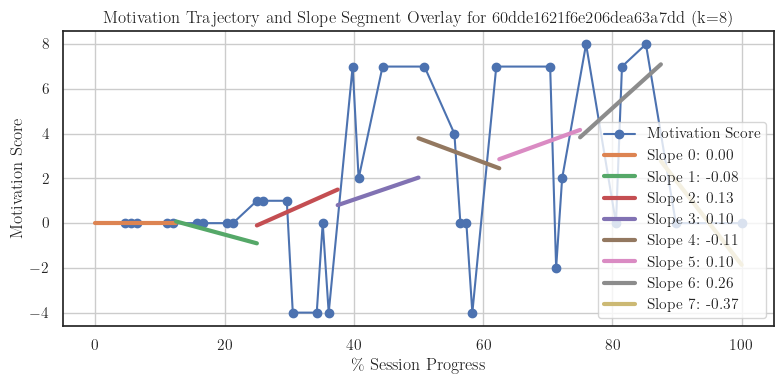

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.961
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00497
Time:                        12:38:27   Log-Likelihood:                -229.85
No. Observations:                 115   AIC:                             477.7
Df Residuals:                     106   BIC:                             502.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2255      0.212      5.790      0.0

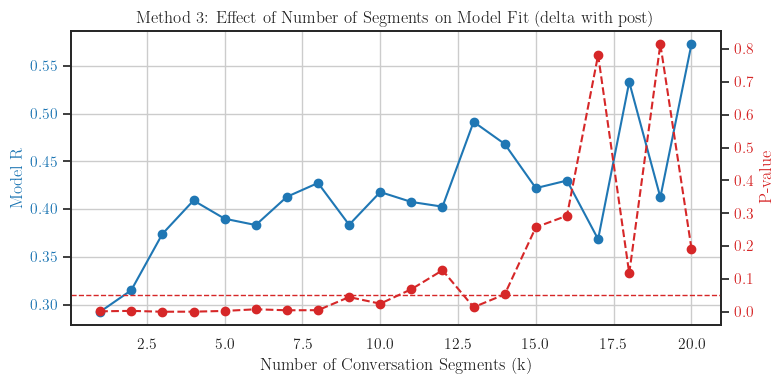

    n_chunks        r2   p-value  n_sessions
0          1  0.292466  0.001515         115
1          2  0.315006  0.002873         115
2          3  0.374026  0.000216         115
3          4  0.409051  0.000431         115
4          5  0.389962  0.002679         115
5          6  0.383324  0.007686         115
6          7  0.412924  0.004658         115
7          8  0.427409  0.004966         115
8          9  0.383585  0.044849         115
9         10  0.417923  0.024699         114
10        11  0.407530  0.068763         110
11        12  0.402581  0.126446         108
12        13  0.491470  0.013999         105
13        14  0.468247  0.053159         104
14        15  0.422010  0.257372         102
15        16  0.429962  0.292531         101
16        17  0.368495  0.781773          95
17        18  0.533171  0.117260          87
18        19  0.412381  0.814706          84
19        20  0.572885  0.192513          76
                            OLS Regression Results     

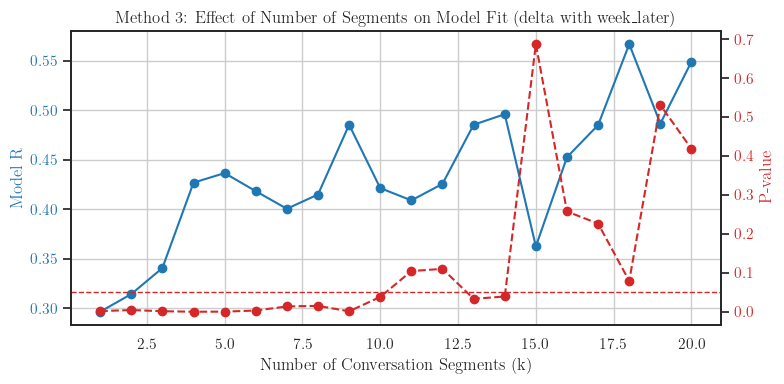

    n_chunks        r2   p-value  n_sessions
0          1  0.296570  0.002022         106
1          2  0.314411  0.004698         106
2          3  0.340726  0.001737         106
3          4  0.427041  0.000392         106
4          5  0.436694  0.000660         106
5          6  0.418417  0.003496         106
6          7  0.400653  0.014040         106
7          8  0.415054  0.015441         106
8          9  0.485569  0.001553         106
9         10  0.421544  0.038363         105
10        11  0.409113  0.104829         101
11        12  0.425787  0.110527          99
12        13  0.485553  0.033593          97
13        14  0.496221  0.039536          96
14        15  0.362630  0.687533          94
15        16  0.452780  0.257808          94
16        17  0.485251  0.226697          89
17        18  0.567007  0.079441          81
18        19  0.486766  0.531110          78
19        20  0.549373  0.418718          70
                            OLS Regression Results     

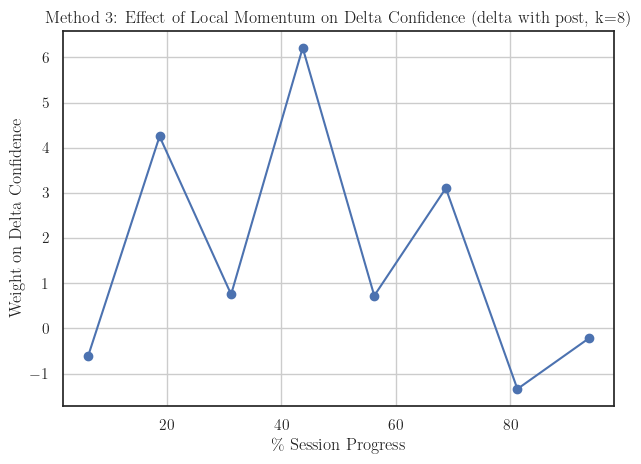

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3.291
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00155
Time:                        12:38:36   Log-Likelihood:                -227.12
No. Observations:                 106   AIC:                             474.2
Df Residuals:                      96   BIC:                             500.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1837      0.258      4.587      0.0

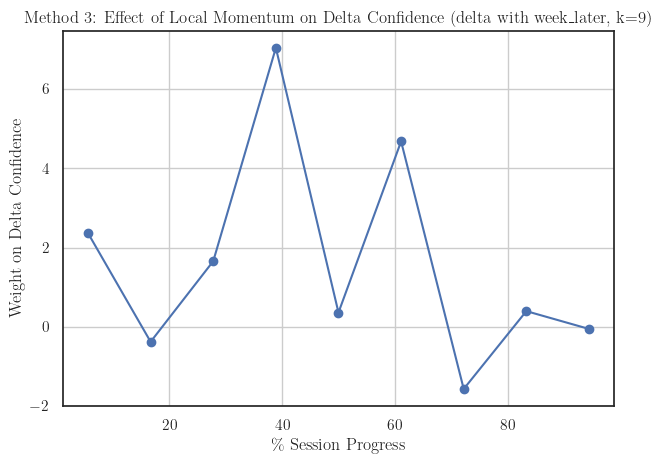

(np.float64(0.23577723431902764), np.float64(0.0015527455187672524), 106)

In [ ]:
df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_lowconf.csv")
# method3(df, delta_with="post", n_chunks=10)
# method3(df, delta_with="week_later", n_chunks=10)

method3(df, delta_with="post", plot_example_pid=True, plot=False, n_chunks=8)




def find_n(upper_bound, delta_with):
    results = []
    for n in range(1,upper_bound+1):
        r2, p, n_ = method3(df, delta_with=delta_with, n_chunks=n)
        # print(f"n_chunks={n} → R²: {r:.3f}, p-value: {p:.3f} (n={n_})")
        results.append((n, np.sqrt(r2), p, n_))
    results_df = pd.DataFrame(results, columns=["n_chunks", "r2", "p-value", "n_sessions"])

    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:blue'
    ax1.plot(results_df['n_chunks'], results_df['r2'], marker='o', color=color)
    ax1.set_ylabel('Model R', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.plot(results_df['n_chunks'], results_df['p-value'], marker='o', linestyle='--', color=color)
    ax2.axhline(y=0.05, color=color, linestyle='--', linewidth=1)
    ax2.set_ylabel('P-value', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel('Number of Conversation Segments (k)')
    plt.title(f'Method 3: Effect of Number of Segments on Model Fit (delta with {delta_with})')
    plt.tight_layout()
    plt.show()

    print(results_df)

# find_n(30, delta_with="post")
find_n(20, delta_with="post")
# find_n(30, delta_with="week_later")
find_n(20, delta_with="week_later")

method3(df, delta_with="post", plot_example_pid=False, plot=True, n_chunks=8)
method3(df, delta_with="week_later", plot_example_pid=False, plot=True, n_chunks=9)


### Method 4: language-based

Loading data...
Total client utterances: 2628
Mapping DARN/CATS labels to strength scores...
Strength scores shape: (2628,)
Example strength scores: [ 0  0 -2 -2 -4 -7  0  0  0  0]
Embedding utterances with Sentence-BERT...


Batches:   0%|          | 0/83 [00:00<?, ?it/s]

Embeddings shape: (2628, 384)
Splitting into train and test sets...
Training set: (2102, 384), Test set: (526, 384)
Fitting Ridge Regression...
Model fitted.
Number of coefficients: 384
Evaluating model on test set...
Test R² score: 0.244
Analyzing feature importance...
Top 20 embedding dimensions contributing to motivational strength:
  1: Dimension 345, Importance 5.5268
  2: Dimension 111, Importance 5.2380
  3: Dimension 244, Importance 4.5354
  4: Dimension 146, Importance 4.2949
  5: Dimension 35, Importance 4.1986
  6: Dimension 272, Importance 4.1936
  7: Dimension 23, Importance 4.1041
  8: Dimension 381, Importance 4.0967
  9: Dimension 252, Importance 4.0848
  10: Dimension 112, Importance 3.9554
  11: Dimension 259, Importance 3.9364
  12: Dimension 102, Importance 3.9229
  13: Dimension 296, Importance 3.9166
  14: Dimension 131, Importance 3.8709
  15: Dimension 326, Importance 3.8518
  16: Dimension 220, Importance 3.8511
  17: Dimension 305, Importance 3.7320
  18: Dime

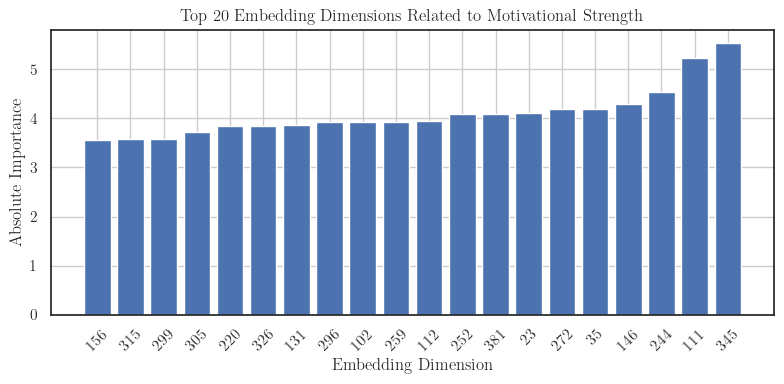

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Step 0: Load Data
print("Loading data...")
df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2_lowconf.csv")
# df = pd.concat([df, pd.read_csv("2024-11-19-MIV6.1B_parsed_aggregated_results_t2.csv")])
# pd.concatenate(df, pd.read_csv("2024-11-19-MIV6.1B_parsed_aggregated_results_t2.csv"))
df_client = df[df["Speaker"] == "client"].copy()
print(f"Total client utterances: {len(df_client)}")

# Step 1: Map DARN/CATS labels to motivational strength scores
print("Mapping DARN/CATS labels to strength scores...")
label_to_strength = {
    "TS-": -8, "AC-": -7, "C-": -6, "N-": -5, "R-": -4, "AB-": -3, "D-": -2, "O-": -1,
    "N": 0,
    "O+": 1, "D+": 2, "AB+": 3, "R+": 4, "N+": 5, "C+": 6, "AC+": 7, "TS+": 8,
}

# Map labels to scores
strengths = df_client["T2 Label (AutoMISC)"].map(label_to_strength).values
print(f"Strength scores shape: {strengths.shape}")
print(f"Example strength scores: {strengths[:10]}")

# Step 2: Embed the utterances
print("Embedding utterances with Sentence-BERT...")
utterances = df_client["Utterance"].tolist()
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(utterances, show_progress_bar=True)
print(f"Embeddings shape: {embeddings.shape}")  # (2628, 384)

# Step 3: Train-test split
print("Splitting into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(embeddings, strengths, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Step 4: Fit Ridge Regression
print("Fitting Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print("Model fitted.")
print(f"Number of coefficients: {len(ridge.coef_)}")

# Step 5: Evaluate model
print("Evaluating model on test set...")
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Test R² score: {r2:.3f}")

# Step 6: Analyze feature importance
print("Analyzing feature importance...")
importance = np.abs(ridge.coef_)

top_k = 20
top_dims = np.argsort(importance)[-top_k:]

print(f"Top {top_k} embedding dimensions contributing to motivational strength:")
for i, dim in enumerate(top_dims[::-1]):  # reverse to show biggest first
    print(f"  {i+1}: Dimension {dim}, Importance {importance[dim]:.4f}")

# Step 7: Plot feature importance
plt.figure(figsize=(8, 4))
plt.bar(range(top_k), importance[top_dims])
plt.xticks(range(top_k), top_dims, rotation=45)
plt.xlabel('Embedding Dimension')
plt.ylabel('Absolute Importance')
plt.title(f'Top {top_k} Embedding Dimensions Related to Motivational Strength')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Pick the most important dimension
important_dim = 345

# Get the value of that dimension for each utterance
dim_values = embeddings[:, important_dim]

# Add it to your dataframe for inspection
df_client["value"] = dim_values

# Sort utterances by this dimension
df_sorted = df_client.sort_values("value", ascending=False)

# Look at top and bottom utterances
print(f"Top utterances (highest Dim{important_dim} values):")
print(df_sorted.head(10)[["Utterance", "T2 Label (AutoMISC)", "value"]])
df_sorted.head(10).to_csv("top_utterances.csv", index=False)

print(f"\nBottom utterances (lowest Dim{important_dim} values):")
print(df_sorted.tail(10)[["Utterance", "T2 Label (AutoMISC)", "value"]])
df_sorted.tail(10).to_csv("bottom_utterances.csv", index=False)

Top utterances (highest Dim345 values):
                                                       Utterance T2 Label (AutoMISC)     value
7659    I just don't know if I will actually go through with it.                 AB-  0.147336
1774                                           fine thanks, you?                   N  0.115402
7634                            It's really tough to go through.                 AC-  0.114851
5403                                                 fine thanks                   N  0.098737
5260                                          It's so difficult.                 AB-  0.098322
848                     it feels like it will be very difficult.                 AB-  0.097402
3899              I'm just from smoking my third cigarette today                   N  0.095731
4968                                                    I'm fine                   N  0.094685
603                                          I'm trying so much.                 TS+  0.093339
268   and 

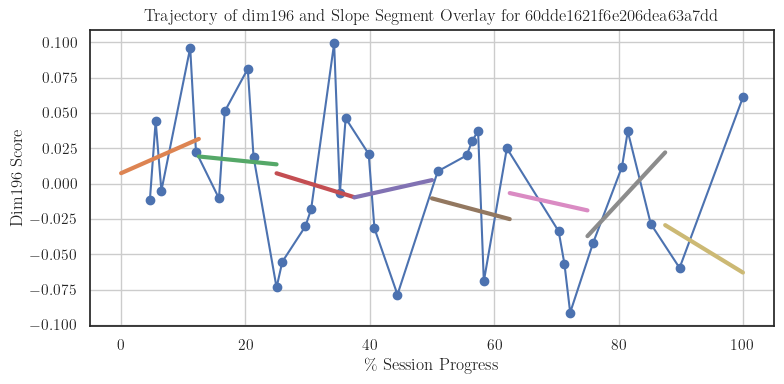

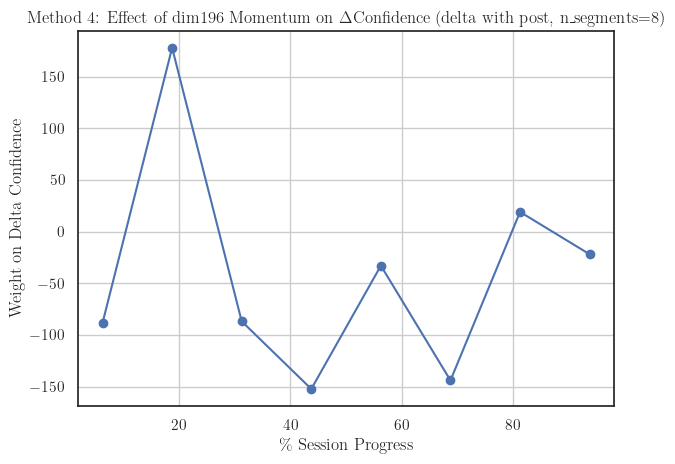

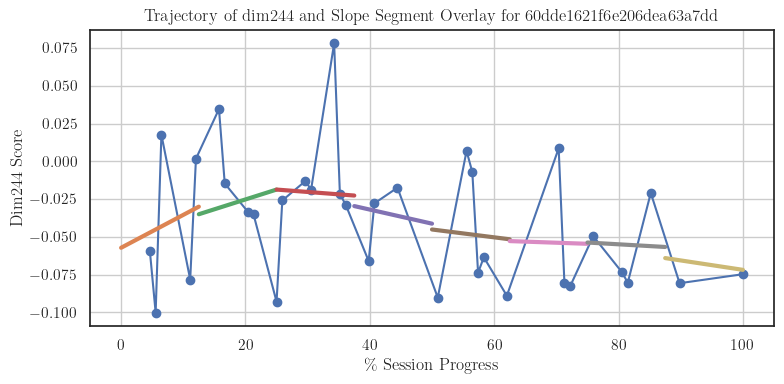

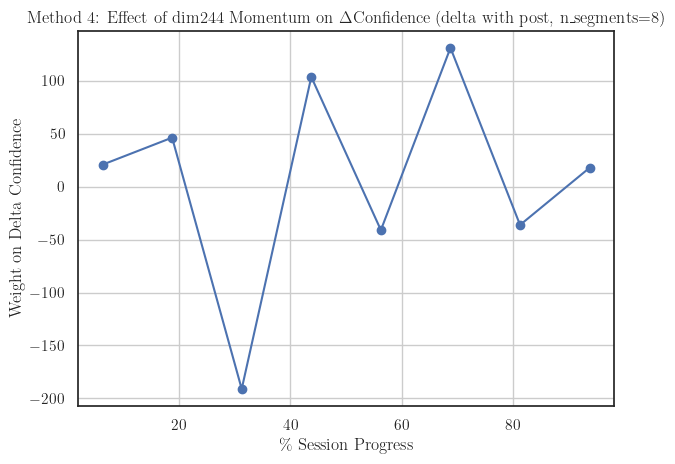

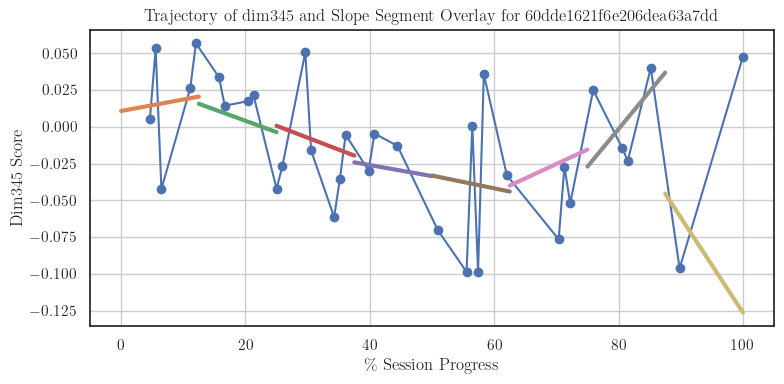

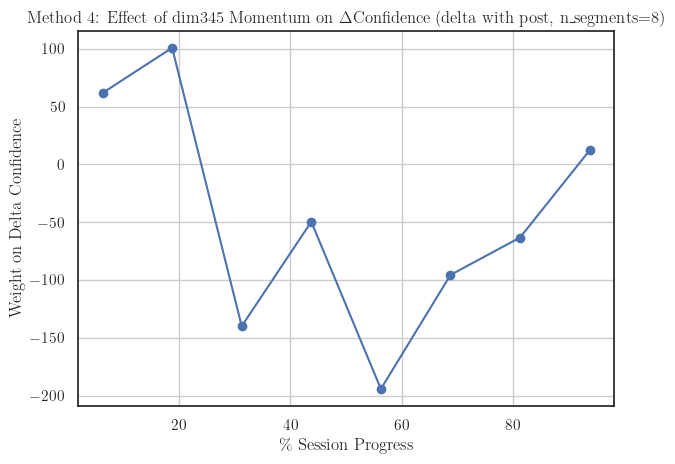

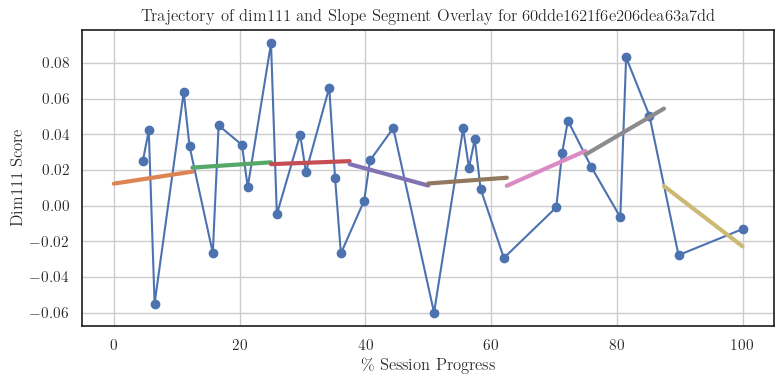

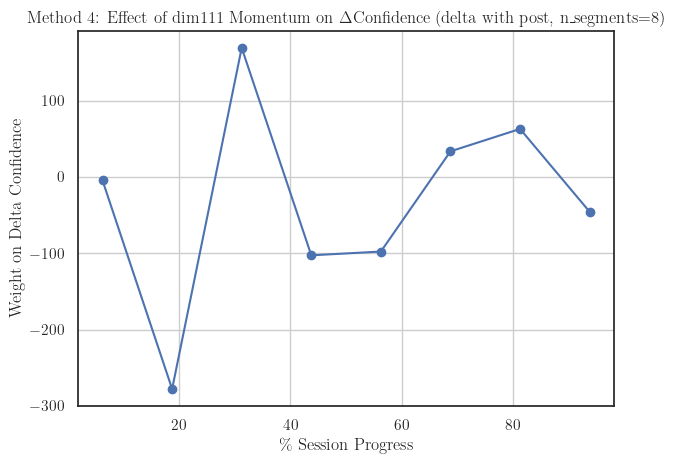

(np.float64(0.07978726356123955), np.float64(0.33727998384855457), 115)

In [ ]:

import statsmodels.api as sm

def method4(df, embeddings, selected_index, delta_with="post", plot_example_pid=False, plot=False, n_chunks=10):
    dim_values = embeddings[:, selected_index]
    df["score"] = np.nan  # initialize all rows as NaN
    client_mask = (df["Speaker"] == "client")
    df.loc[client_mask, "score"] = dim_values

    group = list(df.groupby("Prolific ID", sort=False))

    fd_list = []
    deltas = []
    
    grid_points = np.linspace(0, 100, n_chunks + 1)  # For plotting


    for pid, session in group:
        client_utt = session[session["Speaker"] == "client"].copy()
        y = client_utt['score'].values
        full_indices = session.index
        client_indices = client_utt.index
        session_len = len(full_indices)
        client_locs = np.array([full_indices.get_loc(i) for i in client_indices])

        if len(client_locs) < 5:  # Too few points to reliably split
            print(f"Skipping {pid} due to insufficient data points.")
            continue
        # First compute % session progress for each client utterance
        client_progress = 100 * client_locs / (session_len - 1)

        expected_points_per_chunk = len(client_progress) / n_chunks

        if expected_points_per_chunk < 1:
            # print(f"Skipping {pid} early: too few utterances ({len(client_progress)}) for {n_chunks} chunks.")
            continue

        # Split session into equal-percentage chunks
        split_edges = np.linspace(0, 100, n_chunks + 1)

        slopes = []
        intercepts = []
        for i in range(n_chunks):
            # Select utterances within current % chunk
            lower_bound = split_edges[i-1] if i > 0 else split_edges[i]
            upper_bound = split_edges[i+2] if i < n_chunks - 2 else split_edges[i+1]

            mask = (client_progress >= lower_bound) & (client_progress < upper_bound)
            # mask = (client_progress >= split_edges[i]) & (client_progress < split_edges[i+1])
            
            if mask.sum() < 2:
                slopes.append(0)  # Not enough points to fit a line
                intercepts.append(0)
                # print(f"Skipping chunk {i} for {pid} due to insufficient data points.")
                continue
            
            x_chunk = client_progress[mask]
            y_chunk = y[mask]
            
            coeffs = np.polyfit(x_chunk, y_chunk, 1)  # degree 1
            slopes.append(coeffs[0])
            intercepts.append(coeffs[1])


        if len(slopes) != n_chunks:
            print(f"Skipping {pid} due to broken session.")
            continue  # Skip broken sessions


        # if pid == '60dde1621f6e206dea63a7dd' and delta_with == "post":
        # if pid == '663fd7ca84b7978432d6070b' and delta_with == "post":
        if pid == '60dde1621f6e206dea63a7dd' and plot_example_pid is True:

            plt.figure(figsize=(8, 4))
            # Plot the actual motivation scores over session progress %
            plt.plot(client_progress, y, 'o-', label=f'dim{selected_index} Score')
            
            for i in range(n_chunks):
                # Define x range for the chunk (percent progress)
                x_start = split_edges[i]
                x_end = split_edges[i+1]
                x_line = np.array([x_start, x_end])
                y_line = slopes[i] * (x_line) + intercepts[i]

                plt.plot(x_line, y_line, linewidth=3, label=f'Chunk {i} slope: {slopes[i]:.2f}')
            
            plt.xlabel('\% Session Progress')
            plt.ylabel(f'Dim{selected_index} Score')
            plt.title(f'Trajectory of dim{selected_index} and Slope Segment Overlay for {pid}')
            # plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        pre, post, delta = get_confidence_scores(pid, delta_with)
        if pd.isna(delta):
            # print(f"Skipping {pid} due to missing delta.")
            continue
        fd_list.append(slopes)
        deltas.append(delta)

    
    X = np.vstack(fd_list)  # shape: (n_sessions, 50)
    y = np.array(deltas)   # shape: (n_sessions,)

    X_with_const = sm.add_constant(X)

    model = sm.OLS(y, X_with_const).fit()

    # print(model.summary())
    # r, p = pearsonr(model.fittedvalues, model.model.endog)
    # print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

    # Plot the learned weights
    centers = (grid_points[:-1] + grid_points[1:]) / 2
    if plot:
        plt.plot(centers, model.params[1:], marker='o', label="Slope Weights")
        plt.title(f"Method 4: Effect of dim{selected_index} Momentum on $\Delta$Confidence (delta with {delta_with}, n_segments={n_chunks})")
        plt.xlabel("\% Session Progress")
        plt.ylabel("Weight on Delta Confidence")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return model.rsquared, model.f_pvalue, len(fd_list)

method4(df, embeddings, selected_index=196, delta_with="post", plot_example_pid=True, plot=True, n_chunks=8)
method4(df, embeddings, selected_index=244, delta_with="post", plot_example_pid=True, plot=True, n_chunks=8)
method4(df, embeddings, selected_index=345, delta_with="post", plot_example_pid=True, plot=True, n_chunks=8)
method4(df, embeddings, selected_index=111, delta_with="post", plot_example_pid=True, plot=True, n_chunks=8)



## DTW + time-series k-means

### DTW Distance

/var/folders/q6/9f7qcdgs1kd5vsk_x12vfzlr0000gn/T/ipykernel_24173/71607735.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display



/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning:

h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/



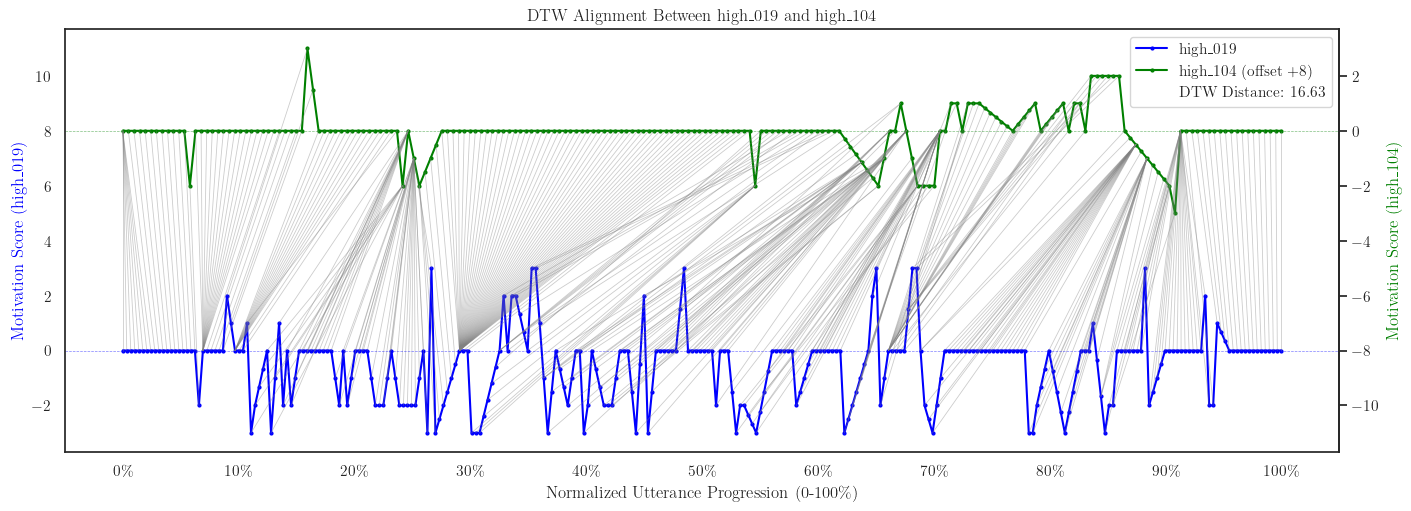

In [ ]:
from IPython.core.display import display, HTML
import plotly.io as pio

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.cell .rendered_html { font-size: 12px; } div.text_cell_render { font-size: 12px; }</style>"))
pio.renderers.default = "browser"
plt.rc("text", usetex=True)
plt.rc("font", family="cm")
pd.set_option("display.max_colwidth", None)

import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw_path

def compare_dtw(pid_1, pid_2, df):
    # Mapping labels to motivation scores
    label_to_score = {
        "TS-": -3, 
        "AC-": -3, 
        "C-": -3, 
        "N-": -2, 
        "R-": -2, 
        "AB-": -2, 
        "D-": -2, 
        "O-": -1,
        "N": 0, 
        "O+": 1,
        "D+": 2, 
        "AB+": 2, 
        "R+": 2, 
        "N+": 2, 
        "C+": 3, 
        "AC+": 3, 
        "TS+": 3, 
    }

    # Filter client utterances and assign scores
    df_client = df[df["Speaker"] == "client"].copy()
    df_client["score"] = df_client["T2 Label (AutoMISC)"].map(label_to_score)

    # Interpolate for each Prolific ID separately
    session_a = df[df["Prolific ID"] == pid_1].copy()
    session_b = df[df["Prolific ID"] == pid_2].copy()

    # Only care about client lines for scoring/interpolation
    session_a["score"] = session_a["T2 Label (AutoMISC)"].map(label_to_score)
    session_b["score"] = session_b["T2 Label (AutoMISC)"].map(label_to_score)

    session_a.loc[session_a["Speaker"] != "client", "score"] = np.nan
    session_b.loc[session_b["Speaker"] != "client", "score"] = np.nan

    session_a_interp = session_a["score"].interpolate(method="linear").bfill().ffill().to_numpy().reshape(-1, 1)
    session_b_interp = session_b["score"].interpolate(method="linear").bfill().ffill().to_numpy().reshape(-1, 1)

    # Compute DTW alignment path
    alignment, dist = dtw_path(session_a_interp, session_b_interp)

    offset = 8  # Visual offset for second session

    fig, ax1 = plt.subplots(figsize=(14, 5), layout="constrained")
    secax = ax1.secondary_yaxis('right', functions=(lambda x: x - offset, lambda x: x + offset))
    secax.set_ylabel(f"Motivation Score ({pid_2})", color="green")

    # Flatten arrays
    a_vals = session_a_interp.flatten()
    b_vals = session_b_interp.flatten()
    b_vals_offset = b_vals + offset

    # X values
    x_a = np.linspace(0, 100, num=len(a_vals))
    x_b = np.linspace(0, 100, num=len(b_vals))

    # Plot both on ax1 to keep the same y-scale
    ax1.plot(x_a, a_vals, label=f"{pid_1}", color="blue", marker='o', linestyle='-', markersize=2)
    ax1.plot(x_b, b_vals_offset, label=f"{pid_2} (offset +{offset})", color="green", marker='o', linestyle='-', markersize=2)
    ax1.plot([], [], ' ', label=f"DTW Distance: {dist:.2f}")

    # Draw alignment lines
    for i, j in alignment:
        ax1.plot([x_a[i], x_b[j]], [a_vals[i], b_vals_offset[j]], color='gray', alpha=0.4, linewidth=0.6)

    # Label axes
    ax1.set_xlabel("Normalized Utterance Progression (0-100\%)")
    ax1.set_ylabel(f"Motivation Score ({pid_1})", color="blue")

    # Draw baseline reference for offset
    ax1.axhline(offset, color='green', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1.axhline(0, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)

    # X-axis ticks
    ax1.set_xticks(np.linspace(0, 100, 11))
    ax1.set_xticklabels([f"{int(x)}\%" for x in np.linspace(0, 100, 11)])

    # Legend
    ax1.legend(loc="best")

    # Title
    plt.title(f"DTW Alignment Between {pid_1} and {pid_2}")
    plt.show()


# df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2.csv")
df = pd.read_csv("HLQC_nolabel_aggregated_results_t2.csv")

compare_dtw('high_019', 'high_104', df)
# compare_dtw('6481e7756969fcd48ea9c634', '671fff4fced93c3e5a17f230', df)



### Clustering

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



dtw_cluster
0    20
1    47
2    57
3    20
4    10
Name: Prolific ID, dtype: int64


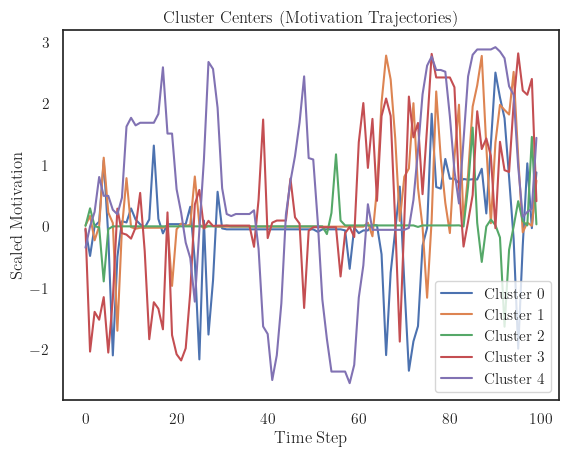

In [ ]:
label_to_score = {
    "TS-": -3, "AC-": -3, "C-": -3, "N-": -2, "R-": -2, "AB-": -2, "D-": -2, "O-": -1,
    "N": 0,
    "D+": 2, "AB+": 2, "R+": 2, "N+": 2, "C+": 3, "AC+": 3, "TS+": 3, "O+": 1,
}

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
import numpy as np
import pandas as pd

def cluster_sessions_by_dtw(df, n_clusters=3, method='normalize', random_state=42):
    """
    Cluster client motivational trajectories using DTW-based TimeSeriesKMeans.

    Parameters:
        df (pd.DataFrame): Your dataframe containing at least ['Prolific ID', 'Speaker', 'Utterance #', 'T2 Label (Soliman)']
        n_clusters (int): Number of clusters to generate
        random_state (int): For reproducibility

    Returns:
        model (TimeSeriesKMeans): Fitted clustering model
        df_labeled (pd.DataFrame): Original df with a new 'dtw_cluster' column
    """

    # Step 1: Get client utterances and score them
    df_client = df[df["Speaker"] == "client"].copy()
    df_client["score"] = df_client["T2 Label (AutoMISC)"].map(label_to_score)

    # Step 2: Interpolate trajectories per session
    session_series = []
    id_to_index = {}
    prolific_ids = df_client["Prolific ID"].unique()

    for idx, pid in enumerate(prolific_ids):
        session = df_client[df_client["Prolific ID"] == pid].copy()
        # session = session.sort_values("Utterance #")  # Ensure chronological order
        session["score"] = session["score"].interpolate(method="linear").bfill().ffill()

        score_series = session["score"].to_numpy().astype(np.float32)

        if method == 'normalize':
            x_original = np.linspace(0, 100, num=len(score_series))
            x_target = np.linspace(0, 100, num=100)
            scores_resampled = np.interp(x_target, x_original, score_series).astype(np.float32)
            session_series.append(scores_resampled.reshape(-1, 1))
        else:
            session_series.append(score_series.reshape(-1, 1))  # Each time series: (timesteps, 1)
        id_to_index[pid] = idx

    # Step 3: Prepare dataset
    X_dataset = to_time_series_dataset(session_series)  # Shape: (n_sessions, max_timesteps, 1)
    # X_scaled = TimeSeriesScalerMinMax().fit_transform(X_dataset)

    # Step 4: DTW-based KMeans clustering
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=random_state)
    # labels = model.fit_predict(X_scaled)
    labels = model.fit_predict(X_dataset)
    
    # Step 5: Map cluster labels back to dataframe
    pid_to_cluster = {pid: labels[i] for pid, i in id_to_index.items()}
    df_labeled = df.copy()
    df_labeled["dtw_cluster"] = df_labeled["Prolific ID"].map(pid_to_cluster)

    print(df_labeled.groupby("dtw_cluster")["Prolific ID"].nunique())

    # To plot cluster centers:
    for i, center in enumerate(model.cluster_centers_):
        plt.plot(center.ravel(), label=f"Cluster {i}")
    plt.title("Cluster Centers (Motivation Trajectories)")
    plt.xlabel("Time Step")
    plt.ylabel("Scaled Motivation")
    plt.legend()
    plt.show()

    return model, df_labeled


# df = pd.read_csv("MIV6.3A_automiscv0.2_aggregated_results_t2.csv")
df = pd.read_csv("HLQC_nolabel_aggregated_results_t2_high.csv")

model, df_labeled = cluster_sessions_by_dtw(df, n_clusters=5)

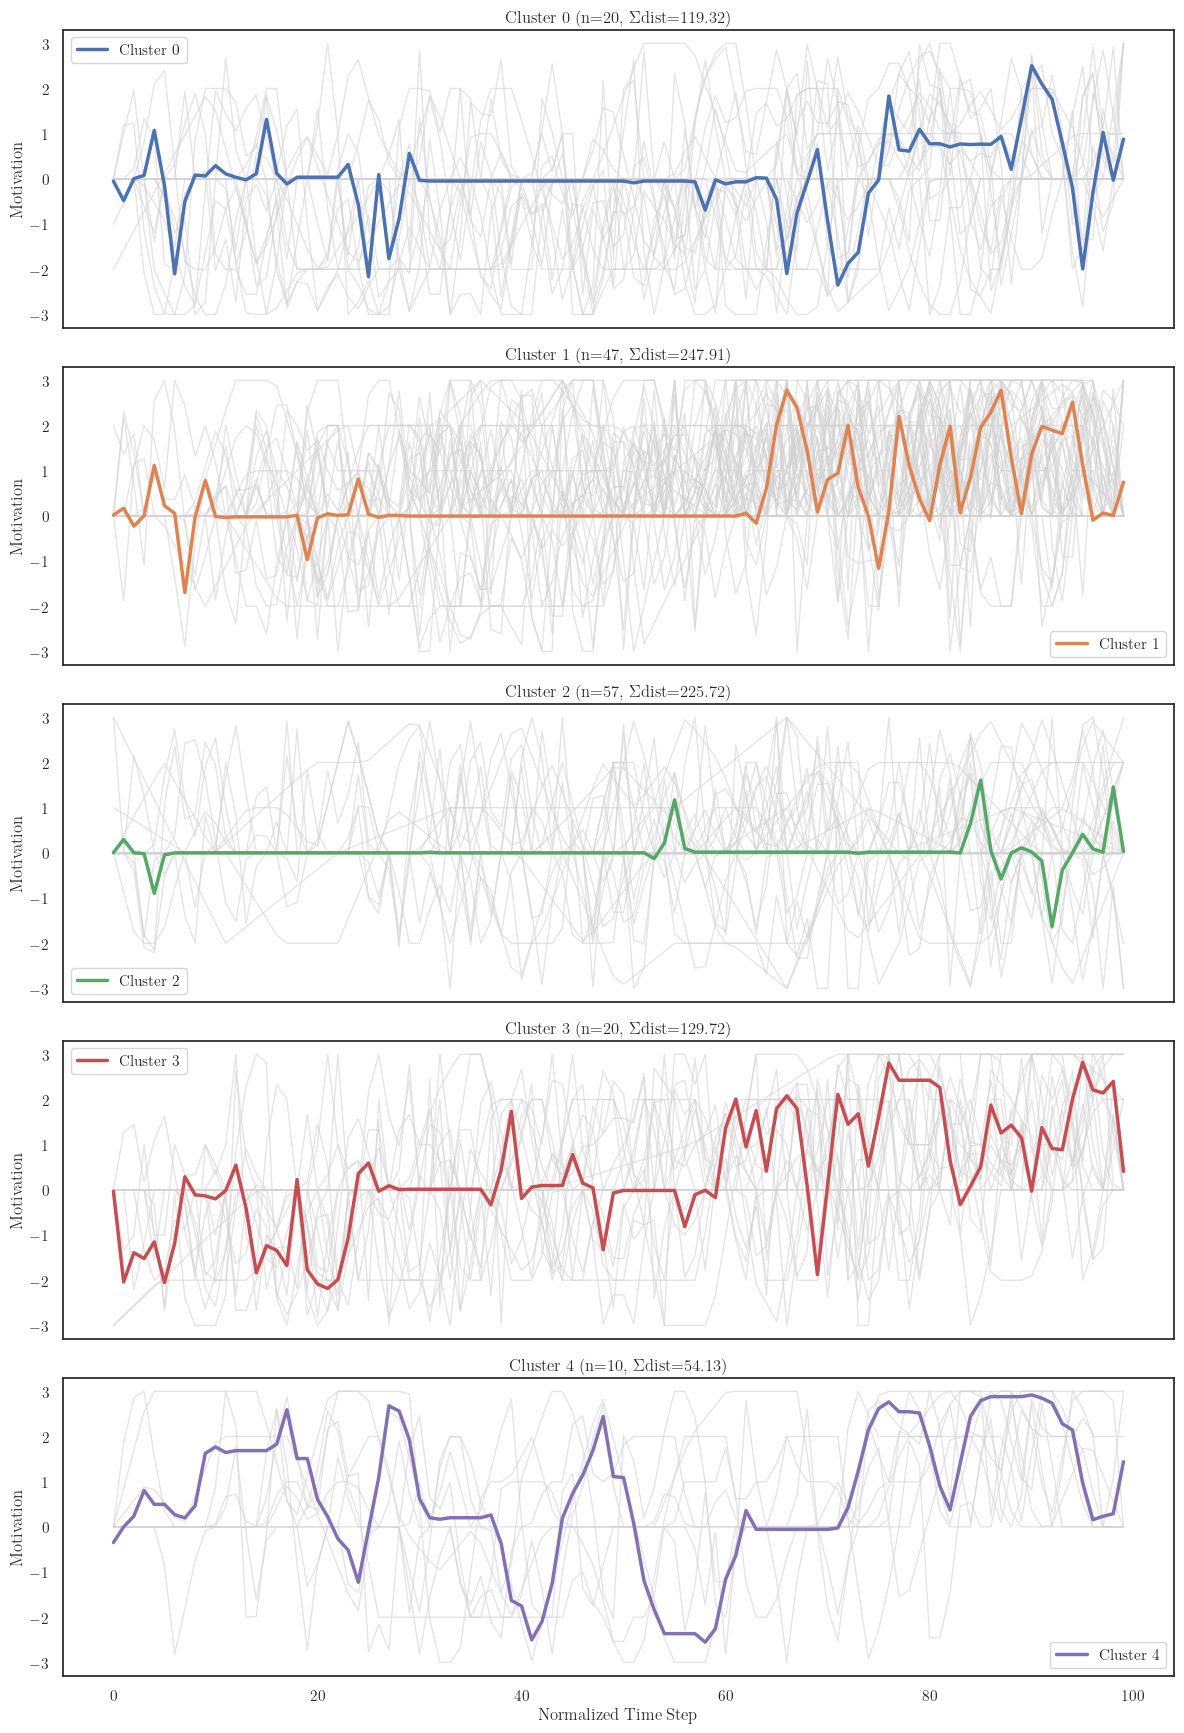


=== Cluster Membership Report with DTW Distances ===

Cluster 2 (n=57) - Total DTW: 225.72
  high_069 - DTW: 2.33
  high_146 - DTW: 2.54
  high_066 - DTW: 2.82
  high_053 - DTW: 2.85
  high_045 - DTW: 2.87
  high_026 - DTW: 2.88
  high_067 - DTW: 2.93
  high_128 - DTW: 2.94
  high_062 - DTW: 2.95
  high_038 - DTW: 2.99
  high_003 - DTW: 3.04
  high_118 - DTW: 3.05
  high_073 - DTW: 3.06
  high_008 - DTW: 3.09
  high_121 - DTW: 3.17
  high_001 - DTW: 3.30
  high_012 - DTW: 3.30
  high_030 - DTW: 3.30
  high_065 - DTW: 3.30
  high_075 - DTW: 3.30
  high_140 - DTW: 3.30
  high_141 - DTW: 3.30
  high_023 - DTW: 3.42
  high_111 - DTW: 3.44
  high_002 - DTW: 3.46
  high_103 - DTW: 3.47
  high_036 - DTW: 3.48
  high_042 - DTW: 3.51
  high_101 - DTW: 3.51
  high_136 - DTW: 3.61
  high_072 - DTW: 3.62
  high_076 - DTW: 3.67
  high_102 - DTW: 3.69
  high_025 - DTW: 3.71
  high_040 - DTW: 3.76
  high_034 - DTW: 3.78
  high_063 - DTW: 3.96
  high_119 - DTW: 4.02
  high_105 - DTW: 4.04
  high_020 

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_cluster_trajectories(model, X_dataset, df_labeled, id_to_index, n_clusters):
    """
    Plot cluster centers with individual session trajectories.
    Also prints Prolific IDs per cluster.
    """
    # Map cluster labels back to Prolific IDs
    cluster_to_ids = defaultdict(list)

    # Plot each cluster
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3.5 * n_clusters), sharex=True)

    if n_clusters == 1:
        axes = [axes]  # ensure iterable if only one cluster

    from tslearn.metrics import dtw

    # Collect distances per cluster and sample
    cluster_distances = defaultdict(float)
    sample_distances = {}

    for pid in df_labeled["Prolific ID"].unique():
        label = df_labeled[df_labeled["Prolific ID"] == pid]["dtw_cluster"].iloc[0]
        idx = id_to_index[pid]
        sample_series = X_dataset[idx].flatten()
        center_series = model.cluster_centers_[label].flatten()
        dist = dtw(sample_series, center_series)
        cluster_distances[label] += dist
        sample_distances[pid] = dist
        cluster_to_ids[label].append(pid)

    # Plotting with cumulative DTW in title
    for cluster_id in range(n_clusters):
        ax = axes[cluster_id]
        center = model.cluster_centers_[cluster_id].flatten()

        for pid in cluster_to_ids[cluster_id]:
            idx = id_to_index[pid]
            series = X_dataset[idx].flatten()
            ax.plot(series, color='lightgray', alpha=0.6, linewidth=1)

        ax.plot(center, color=f"C{cluster_id}", linewidth=2.5, label=f"Cluster {cluster_id}")
        ax.set_title(
            f"Cluster {cluster_id} (n={len(cluster_to_ids[cluster_id])}, "
            f"$\Sigma$dist={cluster_distances[cluster_id]:.2f})"
        )
        ax.set_ylabel("Motivation")
        ax.legend()

    plt.xlabel("Normalized Time Step")
    plt.tight_layout()
    plt.show()

    # Print report of Prolific IDs
    print("\n=== Cluster Membership Report with DTW Distances ===")
    for cluster_id, pids in cluster_to_ids.items():
        print(f"\nCluster {cluster_id} (n={len(pids)}) - Total DTW: {cluster_distances[cluster_id]:.2f}")
        for pid in sorted(pids, key=lambda x: sample_distances[x]):
            print(f"  {pid} - DTW: {sample_distances[pid]:.2f}")

session_series = []
id_to_index = {}
df_client = df[df["Speaker"] == "client"].copy()
df_client["score"] = df_client["T2 Label (AutoMISC)"].map(label_to_score)
prolific_ids = df_client["Prolific ID"].unique()

for idx, pid in enumerate(prolific_ids):
    session = df_client[df_client["Prolific ID"] == pid].copy()
    session["score"] = session["score"].interpolate(method="linear").bfill().ffill()
    score_series = session["score"].to_numpy().astype(np.float32)
    x_original = np.linspace(0, 100, num=len(score_series))
    x_target = np.linspace(0, 100, num=100)
    resampled = np.interp(x_target, x_original, score_series).astype(np.float32)
    session_series.append(resampled.reshape(-1, 1))
    id_to_index[pid] = idx

# Prepare dataset again (without scaling)
from tslearn.utils import to_time_series_dataset
X_dataset = to_time_series_dataset(session_series)

# Plot and report
plot_cluster_trajectories(model, X_dataset, df_labeled, id_to_index, n_clusters=5)

# Comparison to AnnoMI

In [ ]:

def choose_label(row):
    if row["Speaker"].lower() == "client":
        return row["T1 Label"]
    else:
        return row["T2 Label"]

def get_volley_codes(df):

    if not "Label (AutoMISC)" in df.columns:
        df["Label (AutoMISC)"] = df.apply(choose_label, axis=1)

    if not "Volley #" in df.columns:

        volley_number = 0
        previous_volley_text = ""
        previous_speaker = None

        volley_numbers = []

        for index, row in df.iterrows():
            current_volley_text = str(row['Volley (Cumulative)'])

            # If current volley text does NOT start with previous volley text → new volley
            if not current_volley_text.startswith(previous_volley_text) or row['Speaker'] != previous_speaker or row['Prolific ID'] != df.iloc[index - 1]['Prolific ID']:
                volley_number += 1
                previous_speaker = row['Speaker']

            volley_numbers.append(volley_number)

            # Update for next iteration
            previous_volley_text = current_volley_text

        df['Volley #'] = volley_numbers

    grouped = df.groupby(["Prolific ID", "Volley #"], sort=False)

    volley_codes = grouped.agg({
        "Label (AutoMISC)": lambda codes: list(codes),
        "Speaker": "first",  # or "unique" if you want to confirm there's only one speaker 
        "Volley (Cumulative)": "last",
    }).reset_index()

    # volley_codes[volley_codes["Prolific ID"] == 7]
    # volley_codes.to_csv("AnnoMI-volley_codes.csv", index=False)

    return volley_codes

df = pd.read_csv("AnnoMI-parsed_aggregated_results_flat.csv")
# df = pd.read_csv("AnnoMI-parsed_aggregated_results_.csv")

volley_codes = get_volley_codes(df)
volley_codes

,Prolific ID,Volley #,Label (AutoMISC),Speaker,Volley (Cumulative)
0,0,0,"[FI, GI, GI, CQ]",counsellor,Thanks for filling it out. We give this form t...
1,0,1,[N],client,Sure.
2,0,2,"[FA, FA, SR]",counsellor,"So, let's see. It looks that you put-- You dri..."
3,0,3,[N],client,Mm-hmm.
4,0,4,[SR],counsellor,-and you usually have three to four drinks whe...
...,...,...,...,...,...
9694,131,86,[OQ],counsellor,Okay and would you like to come back and see m...
9695,131,87,[AC+],client,"Well, definitely."
9696,131,88,[OQ],counsellor,And what would you like me to do if you don't ...
9697,131,89,[N],client,A nice phone call.


In [ ]:
from collections import Counter

def annoMI_row_to_codes(row):
    codes = []

    # Therapist input
    if row['therapist_input_exists'] == True:
        subtype = str(row['therapist_input_subtype']).lower()
        if subtype == 'information':
            codes.append('GI')
        elif subtype == 'advice':
            # codes.extend(['ADP', 'ADW'])
            codes.extend(['ADVI'])
        elif subtype == 'options':
            # codes.extend(['ADP', 'ADW']) 
            codes.extend(['OPTI'])  
        elif subtype == 'negotiation':
            # codes.extend(['RCP', 'RCW', 'DI', 'WA', 'CO'])
            codes.extend(['NEGO'])

    # Reflection
    if row['reflection_exists'] == True:
        subtype = str(row['reflection_subtype']).lower()
        if subtype == 'simple':
            codes.append('SR')
        elif subtype == 'complex':
            # codes.extend(['CR', 'RF'])
            codes.extend(['CR'])

    # Question
    if row['question_exists'] == True:
        subtype = str(row['question_subtype']).lower()
        if subtype == 'open':
            codes.append('OQ')
        elif subtype == 'closed':
            codes.append('CQ')

    # Other (only if none of the above exist)
    if (
        row['therapist_input_exists'] != True and
        row['reflection_exists'] != True and
        row['question_exists'] != True and
        str(row['main_therapist_behaviour']).lower() == 'other'
    ):
        # codes.extend(['FA', 'FI', 'ST', 'SU', 'AF', 'EC'])
        codes.extend(['O'])

    # Client input
    talk_type = str(row['client_talk_type']).lower()
    if talk_type == 'change':
        codes.append('C')
    elif talk_type == 'sustain':
        codes.append('S')
    elif talk_type == 'neutral':
        codes.append('N')

    return list(set(codes))  # Ensure no duplicates

df = pd.read_csv("AnnoMI-full.csv")

df['AnnoMI Label'] = df.apply(annoMI_row_to_codes, axis=1)

def majority_vote(code_lists):
    all_codes = [code for sublist in code_lists for code in sublist if pd.notna(code)]
    if not all_codes:
        return []
    code_counts = Counter(all_codes)
    max_count = max(code_counts.values())
    # Return all codes tied for the highest count
    majority = [code for code, count in code_counts.items() if count == max_count]
    return sorted(majority)

# Group by transcript_id and volley (assuming "Volley #" is the column name for volley number)

majority_labels = df.groupby(["transcript_id", "utterance_id"], sort=False).agg({
    "AnnoMI Label": lambda code_lists: majority_vote(code_lists),
    "utterance_text": "first"
}).reset_index()

subset = majority_labels

majority_labels = subset.groupby(["transcript_id", "utterance_id"], sort=False).agg({
    "AnnoMI Label": lambda code_lists: majority_vote(code_lists),
    "utterance_text": "first"
}).reset_index()

# majority_labels.to_csv("annoMI_majority_labels.csv", index=False)
majority_labels


,transcript_id,utterance_id,AnnoMI Label,utterance_text
0,0,0,[OQ],Thanks for filling it out. We give this form t...
1,0,1,[N],Sure.
2,0,2,[GI],"So, let's see. It looks that you put-- You dri..."
3,0,3,[N],Mm-hmm.
4,0,4,[GI],-and you usually have three to four drinks whe...
...,...,...,...,...
9694,131,86,"[CQ, NEGO]",Okay and would you like to come back and see m...
9695,131,87,[N],"Well, definitely."
9696,131,88,"[NEGO, OQ]",And what would you like me to do if you don't ...
9697,131,89,[N],A nice phone call.


In [ ]:
min_len = min(len(volley_codes), len(majority_labels))

# tiered_codes = get_volley_codes(pd.read_csv("AnnoMI-parsed_aggregated_results_.csv"))
# flat_codes = get_volley_codes(pd.read_csv("AnnoMI-parsed_aggregated_results_flat.csv"))

merged = pd.concat([
    # tiered_codes.reset_index(drop=True).iloc[:min_len],
    # flat_codes["Label (AutoMISC)"].reset_index(drop=True).iloc[:min_len].rename("Label (Flat AutoMISC)"),
    volley_codes.reset_index(drop=True).iloc[:min_len],
    majority_labels.reset_index(drop=True).iloc[:min_len]
], axis=1)

merged

,Prolific ID,Volley #,Label (AutoMISC),Speaker,Volley (Cumulative),transcript_id,utterance_id,AnnoMI Label,utterance_text
0,0,0,"[FI, GI, GI, CQ]",counsellor,Thanks for filling it out. We give this form t...,0,0,[OQ],Thanks for filling it out. We give this form t...
1,0,1,[N],client,Sure.,0,1,[N],Sure.
2,0,2,"[FA, FA, SR]",counsellor,"So, let's see. It looks that you put-- You dri...",0,2,[GI],"So, let's see. It looks that you put-- You dri..."
3,0,3,[N],client,Mm-hmm.,0,3,[N],Mm-hmm.
4,0,4,[SR],counsellor,-and you usually have three to four drinks whe...,0,4,[GI],-and you usually have three to four drinks whe...
...,...,...,...,...,...,...,...,...,...
9694,131,86,[OQ],counsellor,Okay and would you like to come back and see m...,131,86,"[CQ, NEGO]",Okay and would you like to come back and see m...
9695,131,87,[AC+],client,"Well, definitely.",131,87,[N],"Well, definitely."
9696,131,88,[OQ],counsellor,And what would you like me to do if you don't ...,131,88,"[NEGO, OQ]",And what would you like me to do if you don't ...
9697,131,89,[N],client,A nice phone call.,131,89,[N],A nice phone call.


Number of missing rows: 0
Unique y_true labels: ['N' 'C' 'S']
Unique y_pred labels: ['N' 'C' 'S']
Cohen's Kappa: 0.494
Accuracy: 73.72%


,Prolific ID,Volley #,Label (AutoMISC),Speaker,Volley (Cumulative),transcript_id,utterance_id,AnnoMI Label,utterance_text,AutoMISC Condensed
21,0,21,"[N, O+]",client,"Hmm. Well, that's not good news.",0,21,N,"Hmm. Well, that's not good news.",C
23,0,23,"[O+, R-]",client,"Well, to be honest, I drink sometimes when I'm...",0,23,N,"Well, to be honest, I drink sometimes when I'm...",C
25,0,25,[N],client,"Well, then I feel blur again.",0,25,N,"Well, then I feel blur again.",N
27,0,27,[N],client,Yes on occasion.,0,27,N,Yes on occasion.,N
29,0,29,"[O+, O+]",client,Sometimes I just don't like how much I drink. ...,0,29,N,Sometimes I just don't like how much I drink. ...,C
31,0,31,"[N, O+]",client,"No, it's not like I get crazy or anything but ...",0,31,N,"No, it's not like I get crazy or anything but ...",C
33,0,33,"[N, O+]",client,"Mm-hmm. Yes, sometimes I feel worse after drin...",0,33,N,"Mm-hmm. Yes, sometimes I feel worse after drin...",C
35,0,35,"[AC-, AC+, C+]",client,"Well, I don't think that I'm ready to cut down...",0,35,C,"Well, I don't think that I'm ready to cut down...",C
37,0,37,[AC+],client,I'd say an eight.,0,37,C,I'd say an eight.,C
39,0,39,"[AC+, R+]",client,"Well, I'm more ready than a six because I'm re...",0,39,C,"Well, I'm more ready than a six because I'm re...",C


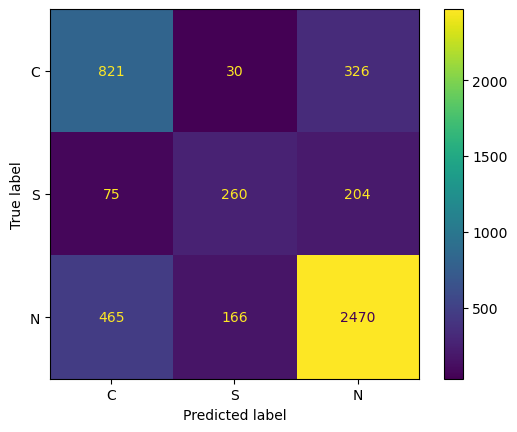

In [ ]:
def reduce_labels(label_list, speaker='client'):
    # print(label_list)
    # map T2 client codes back to T1
    label_mapping = {
        'D+': 'C', 'AB+': 'C', 'R+': 'C', 'N+': 'C', 'C+': 'C', 'O+': 'C', 'TS+': 'C', 'AC+': 'C',
        'D-': 'S', 'AB-': 'S', 'R-': 'S', 'N-': 'S', 'C-': 'S', 'O-': 'S', 'TS-': 'S', 'AC-': 'S',
        'N': 'N',
        'C': 'C', 'S': 'S' # these ones are for T1
    } if speaker == "client" else {
        'ADP': 'ADVI',
        'ADW': 'ADVI',
        'RCP': 'NEGO',
        'RCW': 'NEGO',
        'DI':  'NEGO',
        'WA':  'NEGO',
        'CO':  'NEGO',
        'GI':  'GI',
        'CR':  'CR',
        'RF':  'CR',  # you previously grouped this under complex reflection
        'SR':  'SR',
        'OQ':  'OQ',
        'CQ':  'CQ'
    }

    mapped_labels = [label_mapping[label] for label in label_list if label in label_mapping]
    counts = Counter(mapped_labels)

    # counts = Counter(label_list)
    if not counts:
        return 'N' if speaker == "client" else 'O'

    # Find the label(s) with the highest count
    max_count = max(counts.values())
    majority_labels = [label for label, count in counts.items() if count == max_count]

    # If one clear majority, return it
    if len(majority_labels) == 1:
        return majority_labels[0]
    
    # Tie-breaker: prioritize C > S > N
    if 'C' in majority_labels:
        return 'C'
    elif 'S' in majority_labels:
        return 'S'
    else:
        return 'N'
    
merged["AutoMISC Condensed"] = merged["Label (AutoMISC)"].apply(reduce_labels)

def get_first_label(x):
    if isinstance(x, list):
        return x[0]
    else:
        return x

merged["AnnoMI Label"] = merged["AnnoMI Label"].apply(get_first_label)
# print(merged[merged['Speaker'] == 'client'].head(30))

missing_rows = merged[
    (merged['Speaker'] == 'client') &
    ( (merged["AutoMISC Condensed"].isna()) | (merged["AnnoMI Label"].isna()) )
]

print(f"Number of missing rows: {len(missing_rows)}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get your predictions and ground truth
y_pred = merged[merged['Speaker'] == 'client']["AutoMISC Condensed"]
y_true = merged[merged['Speaker'] == 'client']["AnnoMI Label"]
print("Unique y_true labels:", y_true.unique())
print("Unique y_pred labels:", y_pred.unique())

# Compute confusion matrix
labels = ["C", "S", "N"]  # Ensure consistent label ordering
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred, labels=labels)
print(f"Cohen's Kappa: {kappa:.3f}")

accuracy = (y_true == y_pred).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# merged.to_csv("AnnoMI-merged.csv", index=False)
merged[merged['Speaker'] == 'client'].iloc[10:20]


### Statistical significance: Tiered vs flat

In [ ]:
min_len = min(len(volley_codes), len(majority_labels))

tiered_codes = get_volley_codes(pd.read_csv("AnnoMI-parsed_aggregated_results_.csv"))
flat_codes = get_volley_codes(pd.read_csv("AnnoMI-parsed_aggregated_results_flat.csv"))

merged = pd.concat([
    tiered_codes.reset_index(drop=True).iloc[:min_len],
    flat_codes["Label (AutoMISC)"].reset_index(drop=True).iloc[:min_len].rename("Label (Flat AutoMISC)"),
    # volley_codes.reset_index(drop=True).iloc[:min_len],
    majority_labels.reset_index(drop=True).iloc[:min_len]
], axis=1)

merged["AutoMISC Condensed Tiered"] = merged["Label (AutoMISC)"].apply(reduce_labels)
merged["AutoMISC Condensed Flat"] = merged["Label (Flat AutoMISC)"].apply(reduce_labels)
merged["AnnoMI Label"] = merged["AnnoMI Label"].apply(get_first_label)

merged

,Prolific ID,Volley #,Label (AutoMISC),Speaker,Volley (Cumulative),Label (Flat AutoMISC),transcript_id,utterance_id,AnnoMI Label,utterance_text,AutoMISC Condensed Tiered,AutoMISC Condensed Flat
0,0,1,"[FI, GI, GI, CQ]",counsellor,Thanks for filling it out. We give this form t...,"[FI, GI, GI, CQ]",0,0,OQ,Thanks for filling it out. We give this form t...,N,N
1,0,2,[N],client,Sure.,[N],0,1,N,Sure.,N,N
2,0,3,"[FA, FA, SR]",counsellor,"So, let's see. It looks that you put-- You dri...","[FA, FA, SR]",0,2,GI,"So, let's see. It looks that you put-- You dri...",N,N
3,0,4,[N],client,Mm-hmm.,[N],0,3,N,Mm-hmm.,N,N
4,0,5,[SR],counsellor,-and you usually have three to four drinks whe...,[SR],0,4,GI,-and you usually have three to four drinks whe...,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...
9694,131,9695,[CQ],counsellor,Okay and would you like to come back and see m...,[OQ],131,86,CQ,Okay and would you like to come back and see m...,N,N
9695,131,9696,[C],client,"Well, definitely.",[AC+],131,87,N,"Well, definitely.",C,C
9696,131,9697,[OQ],counsellor,And what would you like me to do if you don't ...,[OQ],131,88,NEGO,And what would you like me to do if you don't ...,N,N
9697,131,9698,[N],client,A nice phone call.,[N],131,89,N,A nice phone call.,N,N


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

y_true = merged[merged['Speaker'] == 'client']["AnnoMI Label"]
y_tiered = merged[merged['Speaker'] == 'client']["AutoMISC Condensed Tiered"]
y_flat = merged[merged['Speaker'] == 'client']["AutoMISC Condensed Flat"]

# y_true: list or array of gold labels
# y_tiered: predictions from Tiered model
# y_flat: predictions from Flat model

tiered_correct = np.array(y_tiered) == np.array(y_true)
flat_correct = np.array(y_flat) == np.array(y_true)

# Build contingency table
#           Flat
#          T   F
# Tiered T a   b
#        F c   d
a = np.sum(tiered_correct & flat_correct)
b = np.sum(tiered_correct & ~flat_correct)
c = np.sum(~tiered_correct & flat_correct)
d = np.sum(~tiered_correct & ~flat_correct)

table = [[a, b],
         [c, d]]

result = mcnemar(table, exact=True)  # use exact=False for large samples
# print("McNemar p-value:", result.pvalue)

print(result)


pvalue      3.480875706240689e-07
statistic   240.0


# Predicting High/Low Label

In [ ]:
# data4 = pd.read_csv("HLQC_nolabel_summary_results_t2_high.csv")
# data5 = pd.read_csv("HLQC_nolabel_summary_results_t2_low.csv")
# data6 = pd.read_csv("2024-11-19-MIV6.1B_parsed_summary_results_t2.csv")

data = pd.read_csv("HLQC_nolabel_summary_results_t2.csv")

# Manually exclude a single data point
# data1 = data1[data1['Conversation ID'] != 'high_052']
# data4 = data4[data4['prolific_id'] != 'high_052']

# data3['%MIC'] = np.where((data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN']) > 0,
#                             100*((data3['MICO'] + data3['R'] + data3['Q'])/ (data3['MICO'] + data3['R'] + data3['Q'] + data3['MIIN'])), 0)

# # group codes and compute %MIC for v2 ones
# for data in [data4, data5, data6]:
data['MICO'] = data['AF'] + data['ADP'] + data['EC'] + data['RCP'] + data['SU'] + data['OQ'] + data['SR'] + data['CR']
data['MIIN'] = data['ADW'] + data['CO'] + data['DI'] + data['RCW'] + data['WA']
data['%MIC'] = np.where((data['MICO'] + data['MIIN']) > 0,
                        100 * (data['MICO'] / (data['MICO'] + data['MIIN'])), 0)
data['R:Q'] = np.where((data['OQ'] + data['CQ']) > 0,
                        (data['SR'] + data['CR']) / (data['OQ'] + data['CQ']), 0)
data['%CT'] = np.where(data['C'] + data['S'] > 0, 
                       100*(data['C'] / (data['C'] + data['S'])), 0)

data['Quality'] = np.where(data['prolific_id'].str.startswith("high"), 1, 0)


data
    

,prolific_id,O,CRL,IMI,Q,IMC,SRL,RCP,RF,OQ,...,O+,AB-,TS-,TS+,MICO,MIIN,%MIC,R:Q,%CT,Quality
0,high_001,8,3,0,4,0,3,0,0,2,...,0,0,0,0,8,0,100.000000,0.750000,0.000000,1
1,high_002,8,1,3,7,1,6,0,0,4,...,0,0,1,1,11,3,78.571429,0.857143,66.666667,1
2,high_003,7,3,10,3,8,0,0,0,1,...,1,0,0,0,5,10,33.333333,0.000000,100.000000,1
3,high_004,2,16,1,7,4,5,0,0,5,...,0,4,0,2,27,1,96.428571,0.714286,50.000000,1
4,high_005,6,0,1,11,0,4,0,0,8,...,7,3,0,0,12,1,92.307692,0.363636,82.352941,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,low_099,1,0,20,4,9,1,0,0,2,...,2,2,0,2,3,20,13.043478,0.250000,63.636364,0
253,low_100,57,2,49,11,0,6,0,0,6,...,0,0,0,0,14,50,21.875000,0.545455,0.000000,0
254,low_101,3,1,11,5,1,1,0,0,1,...,0,0,0,0,3,10,23.076923,0.166667,0.000000,0
255,low_102,5,1,5,8,4,0,0,1,2,...,0,0,0,0,2,5,28.571429,0.000000,0.000000,0


In [ ]:
import statsmodels.api as sm

# Make sure your predictors and outcome are numeric
X_mic = sm.add_constant(data["%MIC"])
X_rq = sm.add_constant(data["R:Q"])
X_ct = sm.add_constant(data["%CT"])
X_all = sm.add_constant(data[["%MIC", "R:Q", "%CT"]])
y = data["Quality"]

# Individual models
model_mic = sm.OLS(y, X_mic).fit()
model_rq = sm.OLS(y, X_rq).fit()
model_ct = sm.OLS(y, X_ct).fit()

# Combined model
model_all = sm.OLS(y, X_all).fit()

# Print summaries
print("Model: %MIC")
print(model_mic.summary())

print("\nModel: R:Q")
print(model_rq.summary())

print("\nModel: %CT")
print(model_ct.summary())

print("\nModel: All Predictors")
print(model_all.summary())

Model: %MIC
                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     364.1
Date:                Fri, 30 May 2025   Prob (F-statistic):           4.94e-51
Time:                        11:02:22   Log-Likelihood:                -67.379
No. Observations:                 257   AIC:                             138.8
Df Residuals:                     255   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2572      0.049     -5.

In [ ]:
import hashlib
import hmac

SECRET_KEY = "DIGITAL_HEALTH_2025" 

def anonymize_id(participant_id: str, secret_key: str = SECRET_KEY) -> str:
    key_bytes = secret_key.encode('utf-8')
    pid_bytes = participant_id.encode('utf-8')
    hashed = hmac.new(key_bytes, pid_bytes, hashlib.sha256)
    return hashed.hexdigest()

df1 = pd.read_csv("2024-11-14-MIV6.3A-2024-11-22-MIV6.3A_all_data_delta_with_week_later_keep_high_conf_False_merged.csv")
df1["Anonymized_participant_id"] = df1["Participant id"].apply(anonymize_id)
df2 = pd.read_csv("../analysis/data/data.csv")

assert df1["Anonymized_participant_id"].equals(df2["ParticipantID"]), "Anonymized IDs do not match!"
df1

,Unnamed: 0,experiment_id,Status,pre_importance,pre_readiness,pre_confidence,post_importance,post_readiness,post_confidence,week_later_importance,...,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,num_fluent_languages,Anonymized_participant_id
0,41,2024-11-14-MIV6.3A,low-confidence-or-discordant,0,0,0,0,0,0,0,...,Female,White,United States,United States,United States,English,No,Full-Time,1,796b23739579e7c3755cda44db7d691d631b889d6f1198...
1,55,2024-11-14-MIV6.3A,low-confidence-or-discordant,6,6,4,8,8,8,7,...,Male,White,United States,United States,United States,English,Yes,Full-Time,2,e15aa92132895e885201fe0bb6d6250dbb831e3d0de66b...
2,97,2024-11-14-MIV6.3A,low-confidence-or-discordant,8,6,4,8,6,4,7,...,Male,Other,Dominican Republic,United States,Dominican Republic,English,No,Full-Time,2,d3f54cd33c0b60a07852ffee13edb21c4b1632a7f6c910...
3,25,2024-11-14-MIV6.3A,low-confidence-or-discordant,7,7,5,5,5,5,9,...,Female,Asian,India,Canada,Canada,English,No,Full-Time,1,2f0426b554b2d574bace0809fc267fee08ebe548e205db...
4,38,2024-11-14-MIV6.3A,low-confidence-or-discordant,6,5,1,6,6,6,6,...,Male,White,United Kingdom,United Kingdom,United Kingdom,English,No,DATA_EXPIRED,2,f8011cdf312facfe2843d3ce6d3f290714c67f4ce21e95...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,3,2024-11-22-MIV6.3A,low-confidence-or-discordant,6,8,3,7,9,4,9,...,Male,White,Canada,Canada,Canada,English,No,Full-Time,1,0110514810081a14412b0109a285d159b0f3750656a2ac...
102,12,2024-11-22-MIV6.3A,low-confidence-or-discordant,3,2,1,4,2,3,2,...,Male,White,United Kingdom,United Kingdom,United Kingdom,English,No,Full-Time,1,2e899743cdc5fce8c15cb25bf2235cd44ad5f797c7b9db...
103,2,2024-11-22-MIV6.3A,low-confidence-or-discordant,2,7,2,4,4,5,4,...,Male,White,United Kingdom,United Kingdom,United Kingdom,English,No,Full-Time,2,218b835cd29a638f9fa77b13baaf1105fb0f1d8be72f8b...
104,13,2024-11-22-MIV6.3A,low-confidence-or-discordant,10,6,5,10,6,6,10,...,Male,White,United States,United States,United States,English,Yes,Full-Time,1,baafbbba33eacc4b4ff7eb764fe24c0286d7760e3a8ca8...
